# Simulating data for the different operator based on K12 decomposition

1. Decompose a dataset
2. Approximate the data, and then sample from a Poisson with these rates (k12_0)
3. Remove one of the GEPs from both W and H, approximate the data and then sample from a Poisson with these rates (K12_m_p[#])
4. Use NMF to decompose the resampled datasets
5. Compare the usages to the original
6. Compare the genes to the original
7. Perform decomposition of K12_m_p[#] using K12_0 GEPs (loss of GEP operator)
8. Perform decomposition of K12_0 using K12_m_p[#] GEPs (gain of GEP operator) 
9. Perform pfnmf with 1, 2, 3 extra GEPs of K12_m_p[#] using K12_0 GEPs (loss of GEP operator)
10. Perform pfnmf with 1, 2, 3 extra GEPs of K12_0 using K12_m_p[#] GEPs (gain of GEP operator)


### Imports and Data Loading

In [1]:
%%time
%load_ext autoreload
%autoreload 2

import sys
import os

from urllib.request import urlretrieve
from argparse import Namespace

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.decomposition import _nmf as sknmf
from sklearn.metrics import jaccard_score
from scipy.stats import rankdata
from scipy.cluster import hierarchy

from gepdynamics import _utils
from gepdynamics import _constants
from gepdynamics import cnmf
from gepdynamics import pfnmf

# Move to the project's home directory, as defined in _constants
_utils.cd_proj_home()
print(os.getcwd())

rng = np.random.default_rng()

/cs/labs/mornitzan/yotamcon/gep-dynamics
CPU times: user 3 s, sys: 1.2 s, total: 4.2 s
Wall time: 1min


In [2]:
%%time
import torch
assert torch.cuda.is_available()
device = 'cuda'

CPU times: user 1.21 s, sys: 358 ms, total: 1.57 s
Wall time: 29.1 s


In [3]:
%%time
results_dir = _utils.set_dir('results')
notebook_dir = _utils.set_dir(results_dir.joinpath('marjanovic_operator_simulation'))
orig_adata_path = results_dir.joinpath('marjanovic_mmLungPlate.h5ad')
split_adatas_dir = _utils.set_dir(results_dir.joinpath('marjanovic_mmLungPlate_split'))

# adata = sc.read(orig_adata_path)
# sc.external.pl.phate(adata, color=['clusterK12', 'timesimple'])
# adata

CPU times: user 436 µs, sys: 163 µs, total: 599 µs
Wall time: 861 µs


### 1. Decomposing the data

In [4]:
subdata = sc.read_h5ad(split_adatas_dir.joinpath('04_K_12w_ND_GEPs.h5ad'))
sname = 'k12'
subdata

AnnData object with n_obs × n_vars = 455 × 30999
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusterK12_colors', 'cnmf_params', 'hvg', 'name', 'sname', 'timesimple_colors'
    obsm: 'X_phate', 'X_tsne', 'row_colors', 'usages', 'usages_norm'
    varm: 'usage_coefs'

In [5]:
# Parameters
beta_loss = 'kullback-leibler'
max_iter = 500

# statistics variable:
prog_usage = 100 * subdata.obsm['usages_norm'].sum(axis=0) / subdata.obsm['usages_norm'].sum()

In [6]:
# Working in the transposed notation to get the GEPs: X.T ~ H.T @ W.T

nmf_kwargs={'H': subdata.obsm['usages'].T.copy(),
            'update_H': False,
            'tol': _constants.NMF_TOLERANCE,
            'max_iter': max_iter,
            'beta_loss': beta_loss
           }

# Variance normalized version of the data
X = sc.pp.scale(subdata.X[:, subdata.var.highly_variable].toarray(), zero_center=False)

tens = torch.tensor(X.T).to(device)

W, H, n_iter = cnmf.nmf_torch(X.T, nmf_kwargs, tens, verbose=True)
print(f'Error per sample = {(sknmf._beta_divergence(X.T, W, H, beta_loss) / subdata.n_obs): .1f}')

del tens

# Normalizing the GEPs so L2 norm == 1
rownorm = np.linalg.norm(W.T, ord=2, axis=1, keepdims=True)

geps = W.T / rownorm
usages = subdata.obsm['usages'] * rownorm.T

geps[geps < np.finfo(geps.dtype).eps**2] = 0
usages[usages < np.finfo(usages.dtype).eps**2] = 0

geps.shape

beta 1 loss = 327476.53125, # iterations was 30
Error per sample =  719.7


(6, 2000)

### 2. Recompose the data and sample counts from Poisson with $WH$ rates

In [7]:
recompositions = {}
orig_prog_names = [f'{sname}.p{i}' for i in range(subdata.uns['cnmf_params']['k_nmf'])]

In [8]:
dict_key = f'{sname}_0'
ns = Namespace(name=dict_key, W=usages, H=geps)

ns.rank = ns.W.shape[1]
ns.data_prog_names = orig_prog_names.copy()
ns.nmf_prog_names = [f'{dict_key}.p{i}' for i in range(ns.rank)]

recompositions[dict_key] = ns

ns.data = rng.poisson(lam=(ns.W @ ns.H)).astype(X.dtype)

ns.data_error = sknmf._beta_divergence(ns.data, ns.W, ns.H, beta_loss) / subdata.n_obs
ns.data_loss_per_cell = pfnmf.calc_beta_divergence(ns.data.T, ns.H.T, np.zeros((ns.H.shape[1], 0)), ns.W.T, np.zeros((0, ns.W.shape[0])), per_column=True)

print(f'Resampled data error per sample = {ns.data_error: .1f}')

print(f'non-zero entries of original data is {np.count_nonzero(X) * 100 / np.multiply(*X.shape): .1f}%')
print(f'non-zero entries of resampled data is {np.count_nonzero(ns.data) * 100 / np.multiply(*ns.data.shape): .1f}%')


# print the keys gained per experiment this far
vars(ns).keys()

Resampled data error per sample =  453.2
non-zero entries of original data is  15.1%
non-zero entries of resampled data is  14.3%


dict_keys(['name', 'W', 'H', 'rank', 'data_prog_names', 'nmf_prog_names', 'data', 'data_error', 'data_loss_per_cell'])

### 3. Recomposing the data without one GEP and sampling counts from Poisson

In [9]:
print(f"Resampled data error per sample = {recompositions[f'{sname}_0'].data_error: .1f}")
print(f'non-zero entries of original data is {np.count_nonzero(X) * 100 / np.multiply(*X.shape): .1f}%\n')

for dropped_GEP_index in range(usages.shape[1]):
    print(f'Dropping gep {dropped_GEP_index}, counting for'
          f' {prog_usage[dropped_GEP_index]: .1f}% of usage')
    
    dict_key = f'{sname}_m_p{dropped_GEP_index}'
    ns = Namespace(
        name=dict_key,
        dropped_GEP_index=dropped_GEP_index,
        W=np.delete(usages, dropped_GEP_index, axis=1),
        H=np.delete(geps, dropped_GEP_index, axis=0))
    
    # Give some value for very small entries
    threshold = 1e-4
    ns.W[ns.W.sum(axis=1) <= threshold, :] += threshold
    ns.H[:, ns.H.sum(axis=0) <= threshold] += threshold
    
    ns.rank = ns.W.shape[1]
    ns.data_prog_names = orig_prog_names.copy()
    ns.data_prog_names.pop(ns.dropped_GEP_index)
    ns.nmf_prog_names = [f'{dict_key}.p{i}' for i in range(ns.rank + 1)]
    ns.nmf_prog_names.pop(ns.dropped_GEP_index)
    
    ns.data = rng.poisson(lam=(ns.W @ ns.H )).astype(X.dtype)
    
    # turn low counts cell closer to their expactation
    expectation = (ns.W @ ns.H).astype(np.float64)
    expectation[expectation < np.finfo(expectation.dtype).eps**2] = 0
    for cell_index in np.where(ns.data.sum(axis=1) < 10)[0]:
        multinomial_proporitons = expectation[cell_index, :]
        multinomial_proporitons /= multinomial_proporitons.astype(np.float64).sum()
        for missing_count in range(10 - int(ns.data[cell_index].sum())):
            ns.data[cell_index, rng.multinomial(1, multinomial_proporitons)] += 1
        
    # turn low counts genes closer to their expactation
    for gene_index in np.where(ns.data.sum(axis=0) < 5)[0]:
        multinomial_proporitons = expectation[:, gene_index]
        multinomial_proporitons /= multinomial_proporitons.astype(np.float64).sum()
        for missing_count in range(5 - int(ns.data[:, gene_index].sum(axis=0))):
            ns.data[rng.multinomial(1, multinomial_proporitons), gene_index] += 1
        
    ns.data_error = sknmf._beta_divergence(ns.data, ns.W, ns.H, beta_loss) / subdata.n_obs
    ns.data_loss_per_cell = pfnmf.calc_beta_divergence(ns.data.T, ns.H.T, np.zeros((ns.H.shape[1], 0)), ns.W.T, np.zeros((0, ns.W.shape[0])), per_column=True)
    
    print(f'Resampled data error per sample = {ns.data_error: .1f}')

    print(f'non-zero entries of resampled data is {np.count_nonzero(ns.data) * 100 / np.multiply(*ns.data.shape): .1f}%\n')
    
    recompositions[dict_key] = ns

Resampled data error per sample =  453.2
non-zero entries of original data is  15.1%

Dropping gep 0, counting for  27.0% of usage
Resampled data error per sample =  375.9
non-zero entries of resampled data is  9.6%

Dropping gep 1, counting for  44.0% of usage
Resampled data error per sample =  333.8
non-zero entries of resampled data is  9.4%

Dropping gep 2, counting for  12.2% of usage
Resampled data error per sample =  420.9
non-zero entries of resampled data is  12.5%

Dropping gep 3, counting for  6.7% of usage
Resampled data error per sample =  437.0
non-zero entries of resampled data is  13.3%

Dropping gep 4, counting for  3.0% of usage
Resampled data error per sample =  451.6
non-zero entries of resampled data is  13.8%

Dropping gep 5, counting for  7.2% of usage
Resampled data error per sample =  439.2
non-zero entries of resampled data is  13.2%



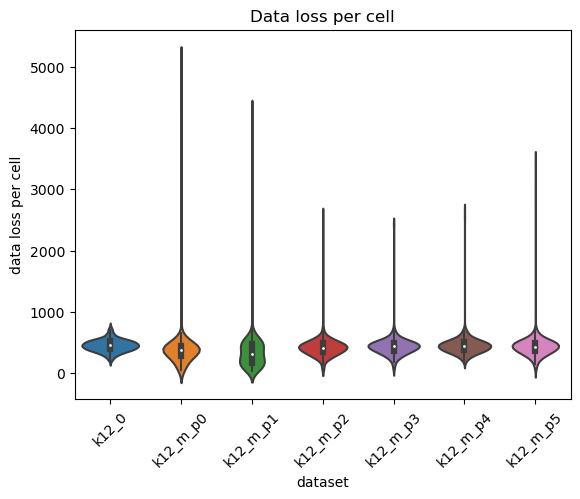

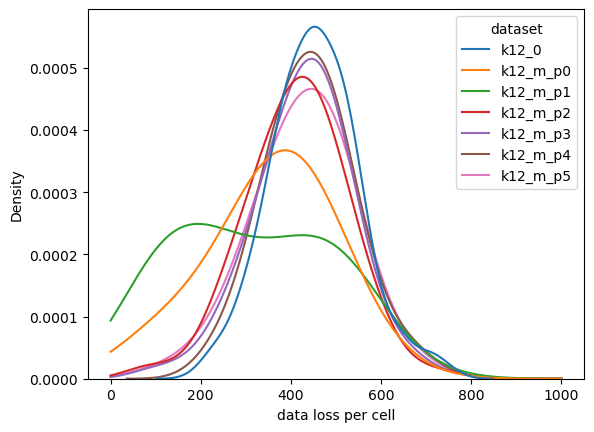

In [10]:
df = pd.concat([pd.Series(ns.data_loss_per_cell, name=name) for name, ns in recompositions.items()], axis=1)
df = pd.melt(df, var_name='dataset', value_name='data loss per cell')

_utils.sns.violinplot(data=df, x="dataset", y="data loss per cell")

plt.title('Data loss per cell')
plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.show()
plt.close()

_utils.sns.kdeplot(df, hue="dataset", x="data loss per cell", clip=(0, 1000))
plt.show()

In [11]:
for name, ns in recompositions.items():
    print('stats for', name)
    print('minimum counts per gene', ns.data.sum(axis=0).min())
    print('minimum counts per cell', ns.data.sum(axis=1).min())
    print('minimum sum of gene across GEPs', ns.H.sum(axis=0).min())
    print('minimum sum of cell usage', ns.W.sum(axis=1).min(), '\n')


stats for k12_0
minimum counts per gene 15.0
minimum counts per cell 75.0
minimum sum of gene across GEPs 0.011560111
minimum sum of cell usage 3.1660993 

stats for k12_m_p0
minimum counts per gene 5.0
minimum counts per cell 11.0
minimum sum of gene across GEPs 0.00011205987
minimum sum of cell usage 0.00010213544 

stats for k12_m_p1
minimum counts per gene 5.0
minimum counts per cell 10.0
minimum sum of gene across GEPs 0.0001168488
minimum sum of cell usage 0.00049999997 

stats for k12_m_p2
minimum counts per gene 5.0
minimum counts per cell 13.0
minimum sum of gene across GEPs 0.00035322204
minimum sum of cell usage 0.0001346232 

stats for k12_m_p3
minimum counts per gene 5.0
minimum counts per cell 20.0
minimum sum of gene across GEPs 0.00015633825
minimum sum of cell usage 0.00049999997 

stats for k12_m_p4
minimum counts per gene 5.0
minimum counts per cell 20.0
minimum sum of gene across GEPs 0.00012766807
minimum sum of cell usage 0.00049999997 

stats for k12_m_p5
minimum

### 4. Use NMF to decompose the resampled datasets

In [12]:
for name, ns in recompositions.items():
    print('working on ', ns.name)
    
    nmf_kwargs={
        'tol': _constants.NMF_TOLERANCE,
        'max_iter': max_iter,
        'beta_loss': beta_loss,
        'n_components': ns.rank
    }
    
    tens = torch.tensor(ns.data).to(device)
    W, H, n_iter = cnmf.nmf_torch(ns.data, nmf_kwargs, tens, verbose=True)
    del tens
    
    ns.nmf_error = sknmf._beta_divergence(ns.data, W, H, beta_loss) / subdata.n_obs
    print(f'Error per sample = {ns.nmf_error: .1f}')   

    ns.nmf_loss_per_cell = pfnmf.calc_beta_divergence(ns.data.T, H.T, np.zeros((H.shape[1], 0)), W.T, np.zeros((0, W.shape[0])), per_column=True)

    # Normalizing the GEPs so L2 norm == 1
    rownorm = np.linalg.norm(H, ord=2, axis=1, keepdims=True)

    ns.H_nmf = H / rownorm
    ns.W_nmf = W * rownorm.T
    
    # Normalized usage
    ns.W_nmf_proportion = ns.W_nmf / ns.W_nmf.sum(axis=0, keepdims=True)
    
    print()

working on  k12_0
beta 1 loss = 201461.96875, # iterations was 90
Error per sample =  442.8

working on  k12_m_p0
beta 1 loss = 154163.484375, # iterations was 220
Error per sample =  338.8

working on  k12_m_p1
beta 1 loss = 137998.59375, # iterations was 90
Error per sample =  303.3

working on  k12_m_p2
beta 1 loss = 183346.859375, # iterations was 90
Error per sample =  403.0

working on  k12_m_p3
beta 1 loss = 191888.703125, # iterations was 100
Error per sample =  421.7

working on  k12_m_p4
beta 1 loss = 198342.1875, # iterations was 90
Error per sample =  435.9

working on  k12_m_p5
beta 1 loss = 192462.46875, # iterations was 100
Error per sample =  423.0



In [13]:
# Rearranging the programs using a permutation matrix
orig_ns = recompositions[f'{sname}_0']

for name, ns in recompositions.items():
    print('working on ', ns.name)
    perm = np.zeros((ns.rank, ns.rank), dtype=int)

    cc = np.corrcoef(orig_ns.W.T, ns.W_nmf.T)[:orig_ns.rank, orig_ns.rank:]

    if vars(ns).get('dropped_GEP_index', -1) >= 0:
        cc = np.delete(cc, ns.dropped_GEP_index, axis=0)

    df = pd.DataFrame(index=np.arange(ns.rank**2))
    df['row'] = df.index // ns.rank
    df['col'] = df.index % ns.rank
    df['val'] = cc.flatten()
    df.sort_values('val', inplace=True, ascending=False, ignore_index=True)

    for index in range(ns.rank):
        row, col = df.iloc[0, 0], df.iloc[0, 1]
        perm[row, col] = 1
        df.drop(df[df.row == row].index, inplace=True)
        df.drop(df[df.col == col].index, inplace=True)

    # print(perm)
    
    ns.H_nmf = perm @ ns.H_nmf
    ns.W_nmf = ns.W_nmf @ perm.T
    
    # Normalized usage
    ns.W_nmf_proportion = ns.W_nmf_proportion @ perm.T

working on  k12_0
working on  k12_m_p0
working on  k12_m_p1
working on  k12_m_p2
working on  k12_m_p3
working on  k12_m_p4
working on  k12_m_p5


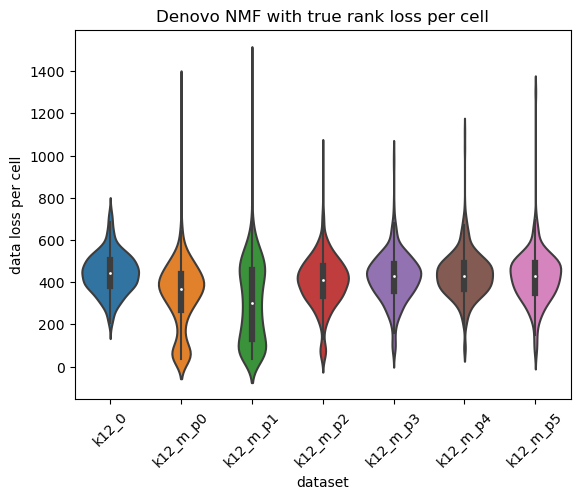

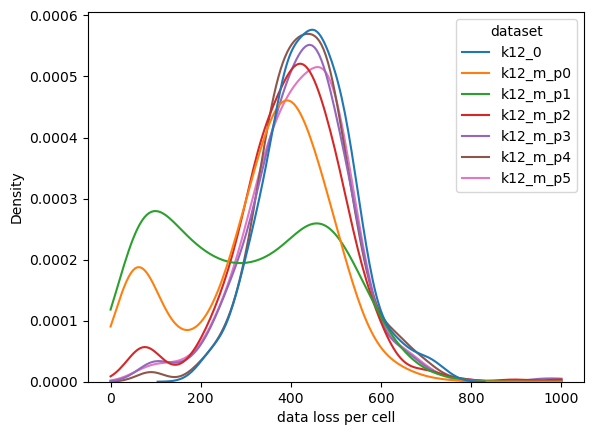

In [14]:
df = pd.concat([pd.Series(ns.nmf_loss_per_cell, name=name) for name, ns in recompositions.items()], axis=1)
df = pd.melt(df, var_name='dataset', value_name='data loss per cell')

_utils.sns.violinplot(data=df, x="dataset", y="data loss per cell")

plt.title('Denovo NMF with true rank loss per cell')
plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.show()
plt.close()

_utils.sns.kdeplot(df, hue="dataset", x="data loss per cell", clip=(0, 1000))
plt.show()

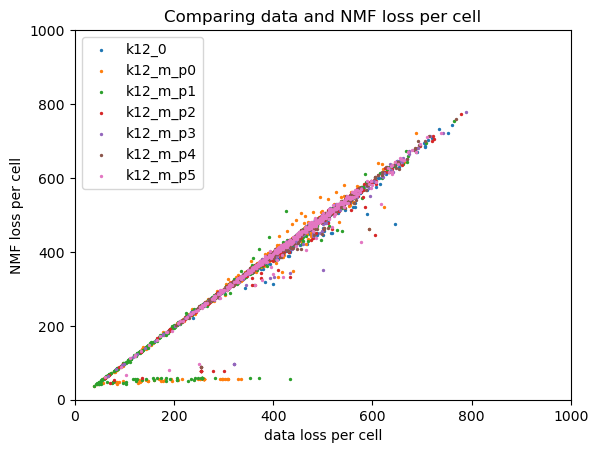

In [15]:
for name, ns in recompositions.items():
    plt.scatter(ns.data_loss_per_cell, ns.nmf_loss_per_cell, label=name, s=2)

plt.title('Comparing data and NMF loss per cell')

plt.xlabel('data loss per cell')
plt.xlim((0, 1000))

plt.ylabel('NMF loss per cell')
plt.ylim((0, 1000))
plt.legend()
plt.show()

### 5. Compare the usages to the original


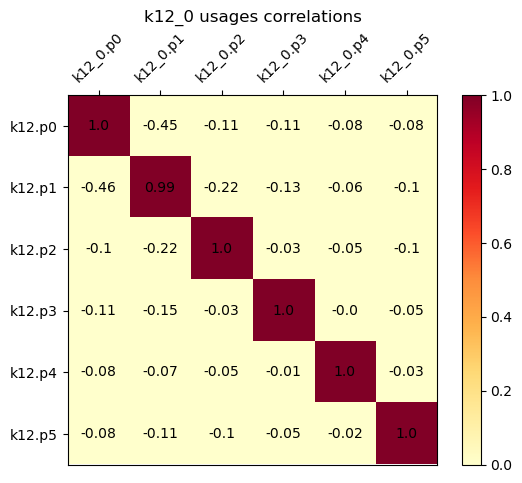

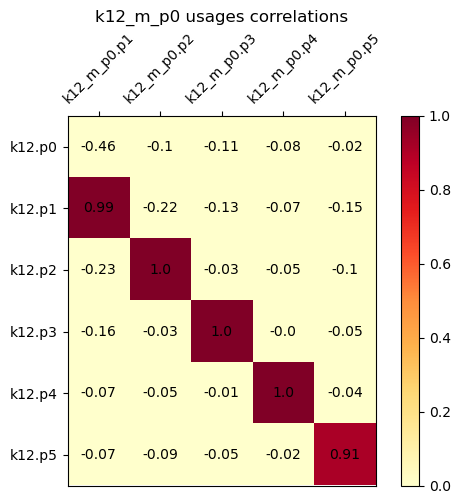

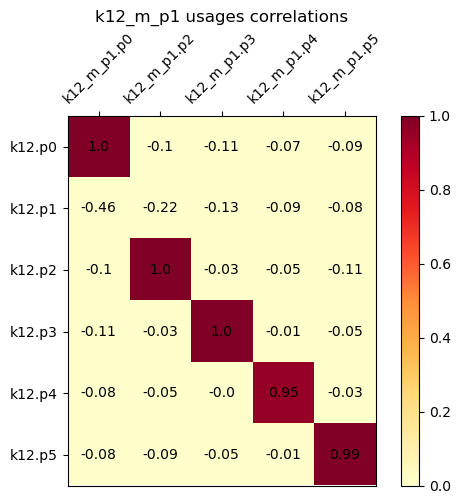

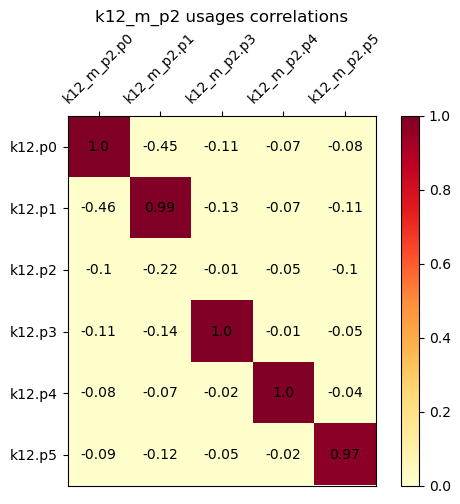

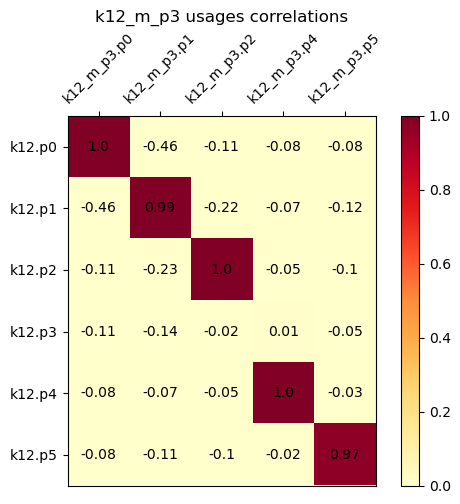

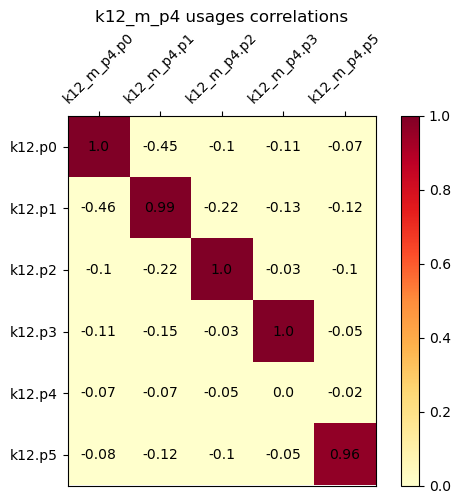

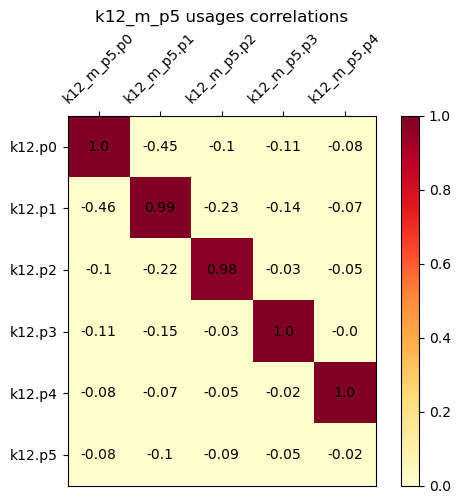

In [16]:
for name, ns in recompositions.items():

    ax = _utils.heatmap_with_numbers(
        np.corrcoef(orig_ns.W.T, ns.W_nmf.T)[:orig_ns.rank, orig_ns.rank:],
        title=f'{name} usages correlations', param_dict={'vmin': 0, 'vmax': 1})

    ax.set_xticks(ticks=ax.get_xticks(), labels=ns.nmf_prog_names)
    ax.set_yticks(ticks=ax.get_yticks(), labels=orig_ns.data_prog_names)
    ax.tick_params(axis='x', labelrotation = 45)

    plt.show()
    plt.close()

### 6. Compare the genes to the original

In [17]:
# Extracting coefficients:
z_layer = 'cpm_log1p_zscore'

subdata.layers[z_layer] = sc.pp.normalize_total(subdata, target_sum=1e6, inplace=False)['X']
sc.pp.log1p(subdata, layer=z_layer)
sc.pp.scale(subdata, layer=z_layer)

orig_ns.data_gene_coefs = pd.DataFrame(
    _utils.fastols(orig_ns.W_nmf_proportion, subdata.layers[z_layer]).T,
    index=subdata.var.index,
    columns=orig_ns.data_prog_names)

for name, ns in recompositions.items():
    ns.nmf_gene_coefs = pd.DataFrame(
        _utils.fastols(ns.W_nmf_proportion, subdata.layers[z_layer]).T,
        index=subdata.var.index,
        columns=ns.nmf_prog_names)

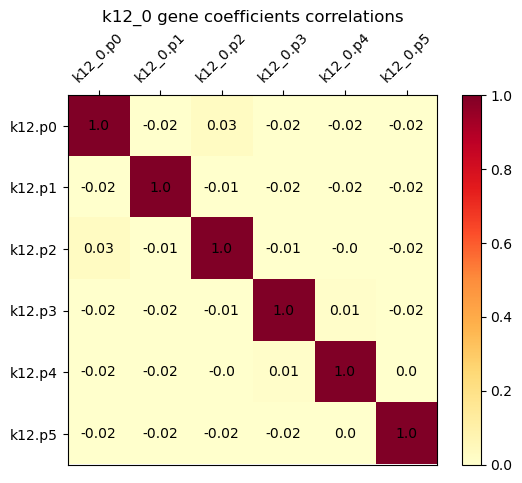

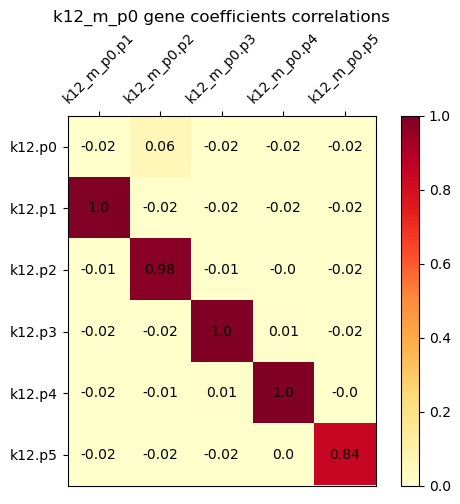

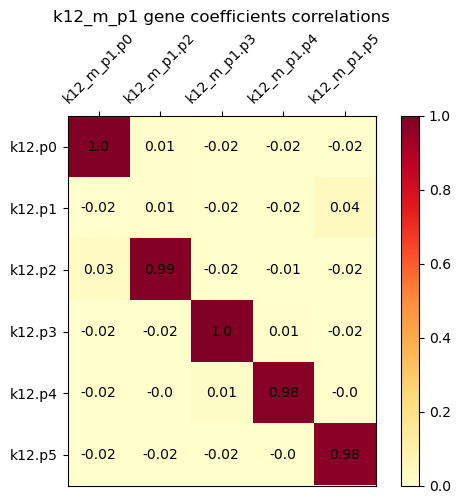

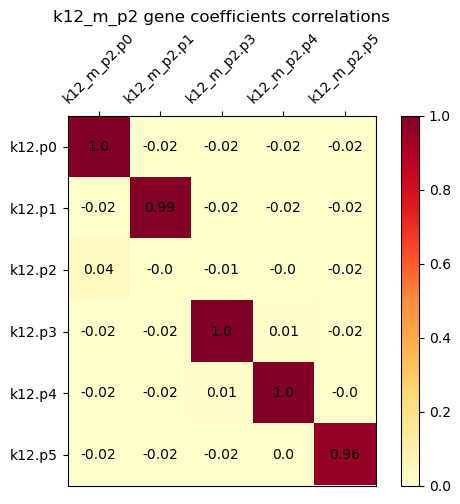

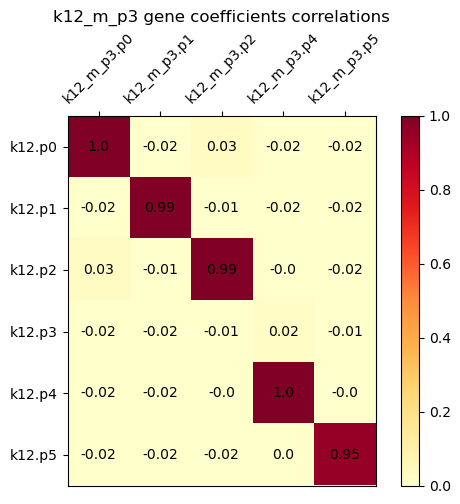

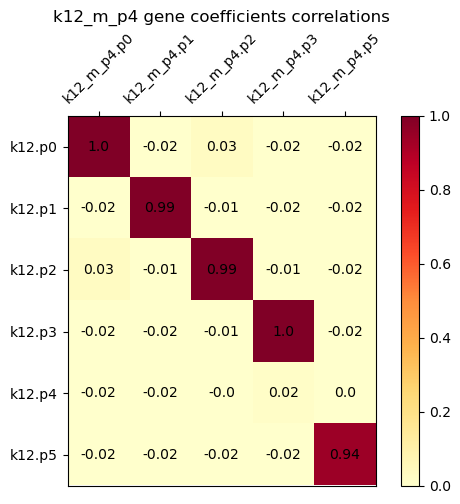

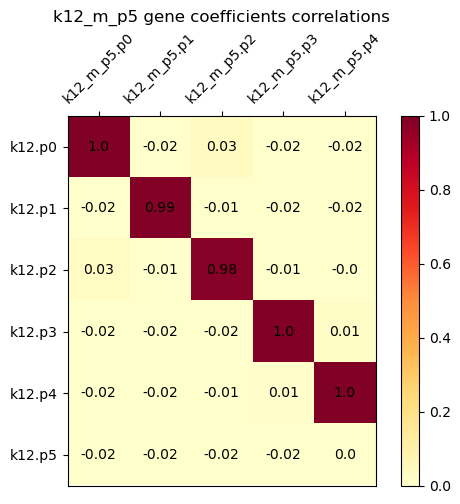

In [18]:
for name, ns in recompositions.items():
    concatenated_spectras = pd.concat([orig_ns.data_gene_coefs, ns.nmf_gene_coefs], axis=1)

    n_genes, n_programs = concatenated_spectras.shape

    ranked_coefs = n_genes - rankdata(concatenated_spectras, axis=0)

    ranked_coefs[ranked_coefs > _constants.N_COMPARED_RANKED] = _constants.N_COMPARED_RANKED

    spearman_corr = np.corrcoef(ranked_coefs, rowvar=False)
    
    ax = _utils.heatmap_with_numbers(
        spearman_corr[:orig_ns.rank, orig_ns.rank:],
        title=f'{name} gene coefficients correlations', param_dict={'vmin': 0, 'vmax': 1})

    ax.set_xticks(ticks=ax.get_xticks(), labels=ns.nmf_prog_names)
    ax.set_yticks(ticks=ax.get_yticks(), labels=orig_ns.data_prog_names)
    ax.tick_params(axis='x', labelrotation = 45)

    plt.show()
    plt.close()

### 7. Perform decomposition of K12_m_p[#] using K12 GEPs (loss of GEP operator)

In [19]:
#  k12_m_p[].data ~ W @ k12_0.nmf_H

orig_ns = recompositions[f'{sname}_0']

for name, ns in recompositions.items():
    print('working on ', ns.name)
    
    nmf_kwargs={'H': orig_ns.H.copy(),
                'update_H': False,
                'tol': _constants.NMF_TOLERANCE,
                'max_iter': max_iter,
                'beta_loss': beta_loss
               }
    
    tens = torch.tensor(ns.data).to(device)   
    W, H, n_iter = cnmf.nmf_torch(ns.data, nmf_kwargs, tens, verbose=True)
    del tens

    ns.pfnmf_error = []
    ns.pfnmf_error.append(sknmf._beta_divergence(ns.data, W, H, beta_loss) / subdata.n_obs)
    print(f'Error per sample = {ns.pfnmf_error[-1]: .1f}')

    ns.pfnmf0_loss_per_cell = pfnmf.calc_beta_divergence(ns.data.T, H.T, np.zeros((H.shape[1], 0)), W.T, np.zeros((0, W.shape[0])), per_column=True)

    
    ns.W_pfnmf = []
    ns.W_pfnmf.append(W)
    
    print()

working on  k12_0
beta 1 loss = 205385.0, # iterations was 60
Error per sample =  451.4

working on  k12_m_p0
beta 1 loss = 157732.140625, # iterations was 70
Error per sample =  346.7

working on  k12_m_p1
beta 1 loss = 141481.703125, # iterations was 60
Error per sample =  310.9

working on  k12_m_p2
beta 1 loss = 186237.203125, # iterations was 60
Error per sample =  409.3

working on  k12_m_p3
beta 1 loss = 194080.46875, # iterations was 60
Error per sample =  426.6

working on  k12_m_p4
beta 1 loss = 200312.65625, # iterations was 60
Error per sample =  440.2

working on  k12_m_p5
beta 1 loss = 193870.171875, # iterations was 60
Error per sample =  426.1



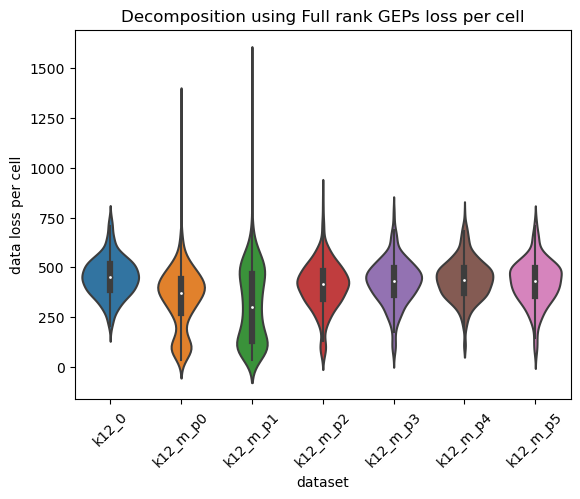

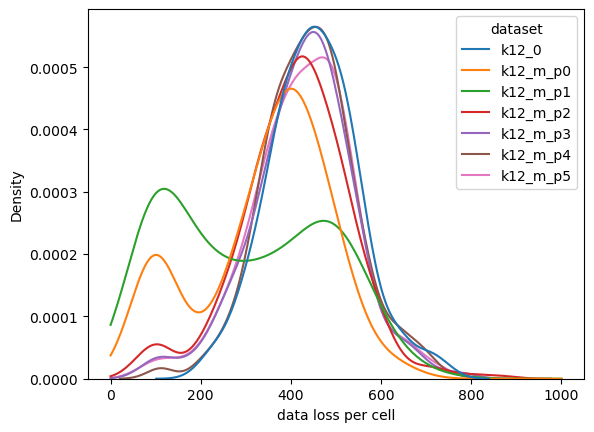

In [20]:
df = pd.concat([pd.Series(ns.pfnmf0_loss_per_cell, name=name) for name, ns in recompositions.items()], axis=1)
df = pd.melt(df, var_name='dataset', value_name='data loss per cell')

_utils.sns.violinplot(data=df, x="dataset", y="data loss per cell")

plt.title('Decomposition using Full rank GEPs loss per cell')
plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.show()
plt.close()

_utils.sns.kdeplot(df, hue="dataset", x="data loss per cell", clip=(0, 1000))
plt.show()

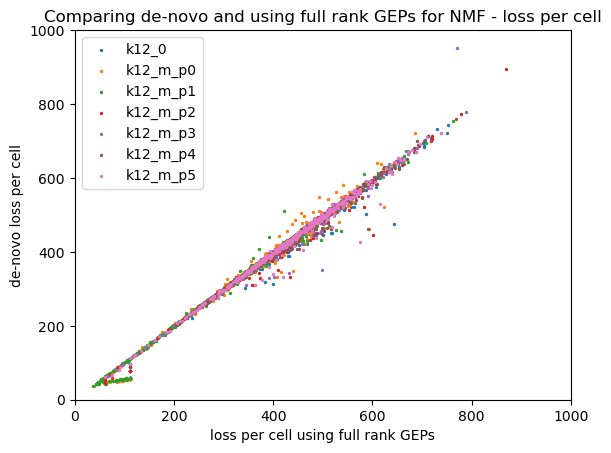

In [21]:
for name, ns in recompositions.items():
    plt.scatter(ns.pfnmf0_loss_per_cell, ns.nmf_loss_per_cell, label=name, s=2)

plt.title('Comparing de-novo and using full rank GEPs for NMF - loss per cell')

plt.xlabel('loss per cell using full rank GEPs')
plt.xlim((0, 1000))

plt.ylabel('de-novo loss per cell')
plt.ylim((0, 1000))
plt.legend()
plt.show()

#### usages comparisons
Results came out clear as expected

working on  k12_0


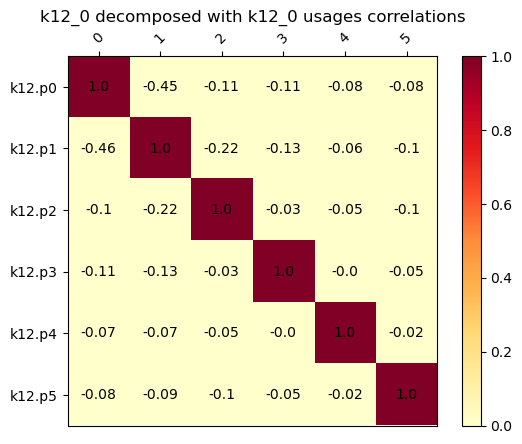

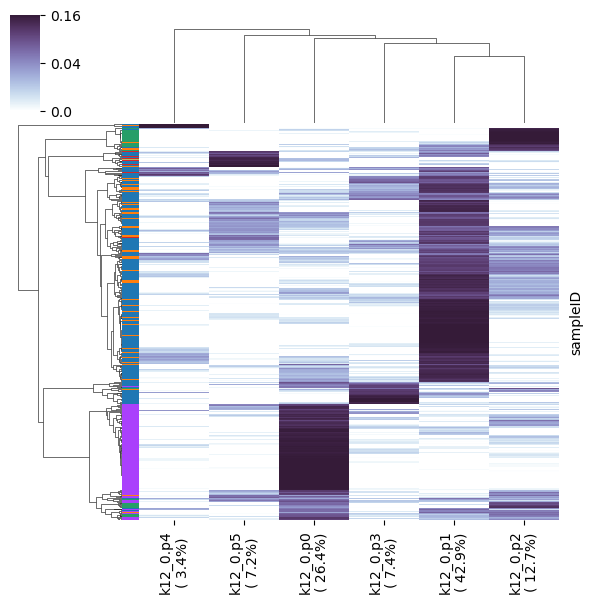

working on  k12_m_p0


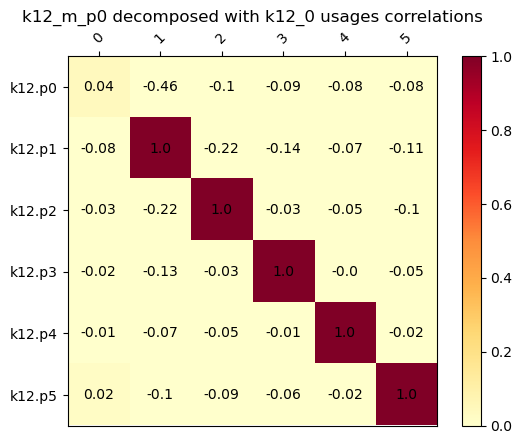

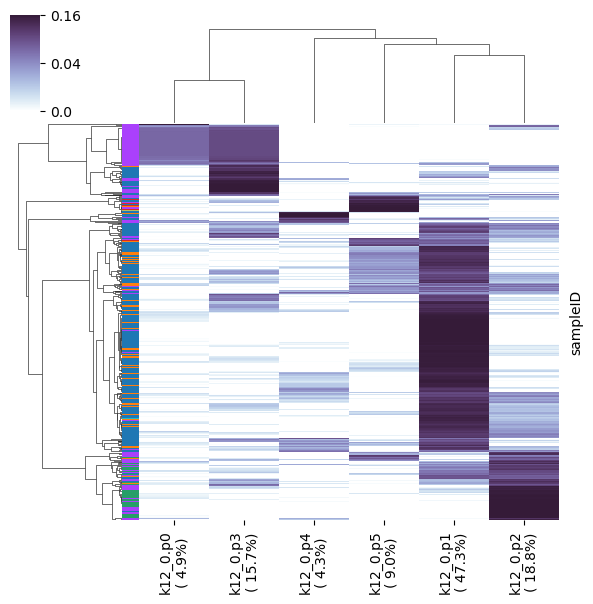

working on  k12_m_p1


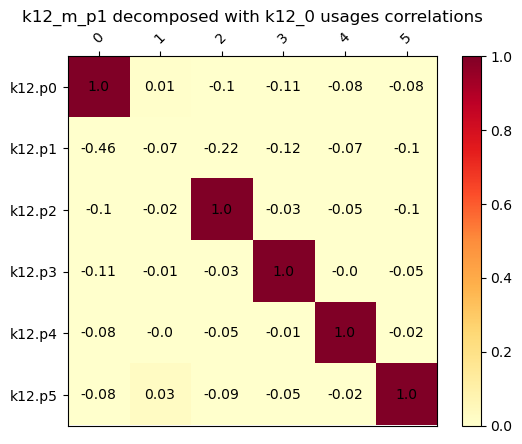

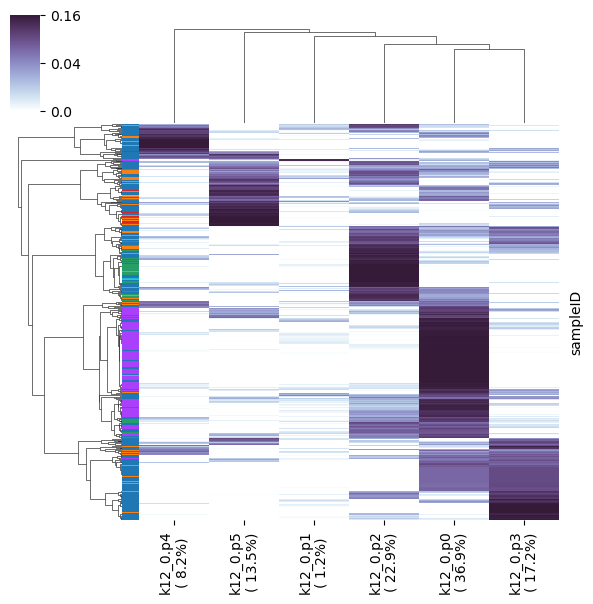

working on  k12_m_p2


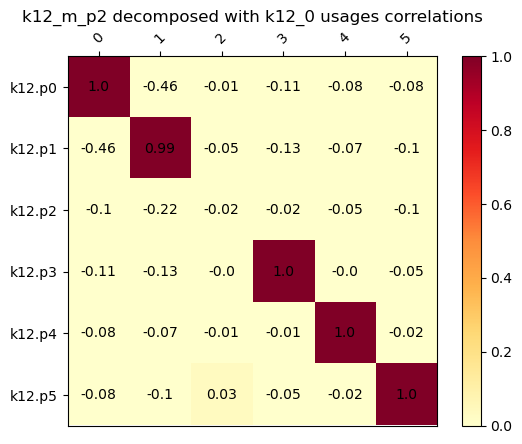

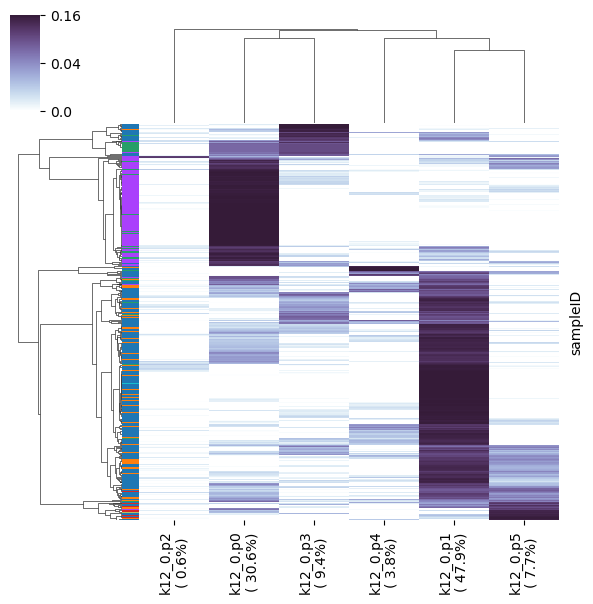

working on  k12_m_p3


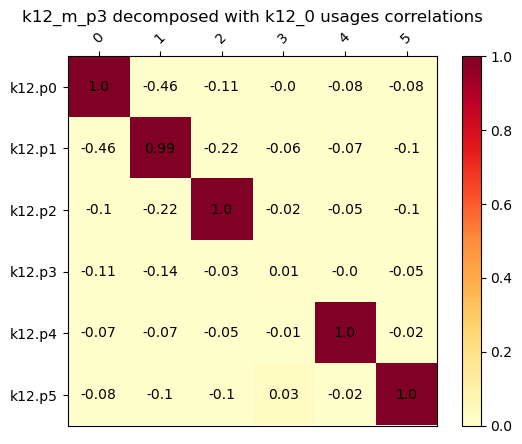

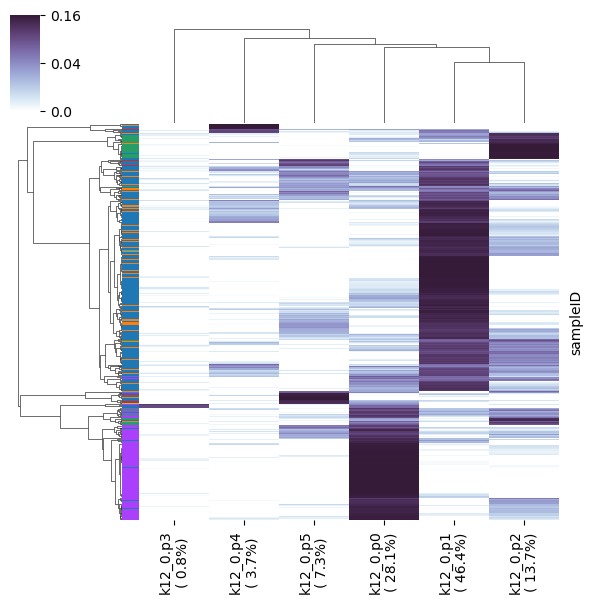

working on  k12_m_p4


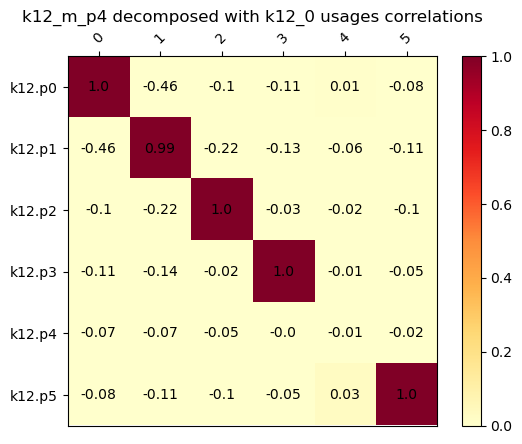

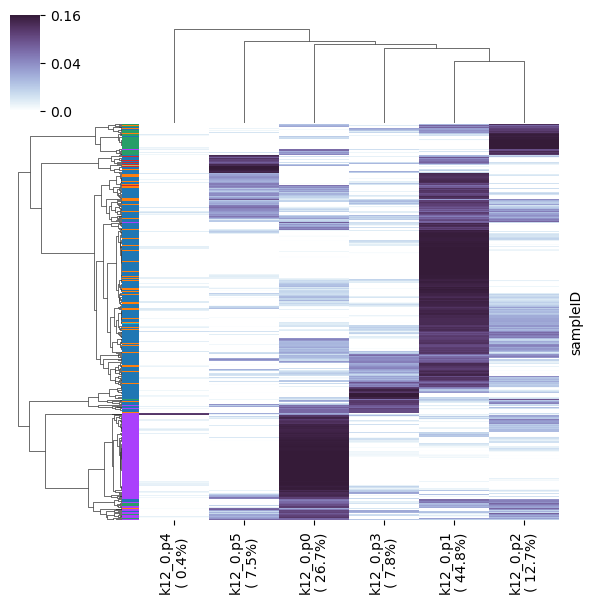

working on  k12_m_p5


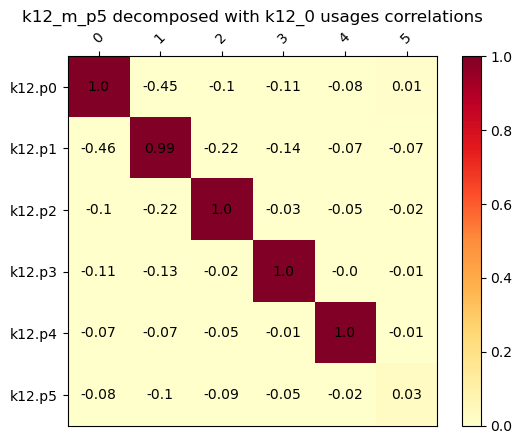

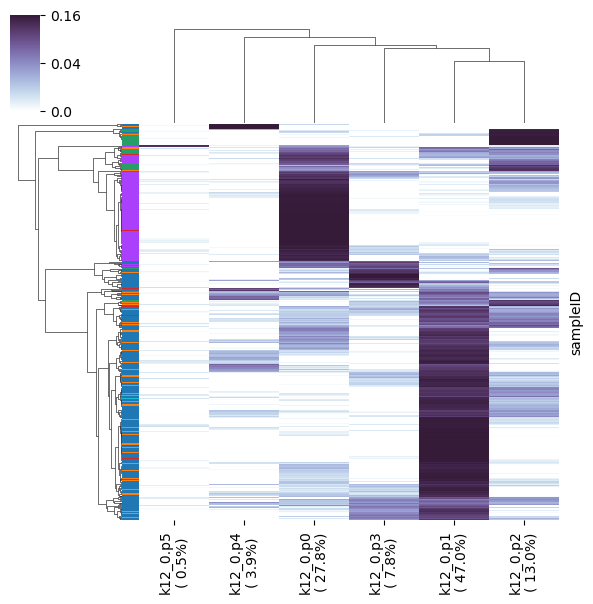

In [22]:
for name, ns in recompositions.items():
    print('working on ', ns.name)
        
    ax = _utils.heatmap_with_numbers(
        np.corrcoef(orig_ns.W.T, ns.W_pfnmf[0].T)[:orig_ns.rank, orig_ns.rank:],
        title=f'{name} decomposed with k12_0 usages correlations', param_dict={'vmin': 0, 'vmax': 1})

    # ax.set_xticks(ticks=ax.get_xticks(), labels=ns.nmf_prog_names)
    ax.set_yticks(ticks=ax.get_yticks(), labels=orig_ns.data_prog_names)
    ax.tick_params(axis='x', labelrotation = 45)

    plt.show()
    plt.close()

    
    title = f'{name} decomposed with k12_0 GEPs, normalized usages'

    eps_W = ns.W_pfnmf[0] + np.finfo(float).eps**2
    normalized_usages = (eps_W  / (eps_W.sum(axis=1, keepdims=True)))
    normalized_usages[eps_W.sum(axis=1) < np.finfo(float).eps] = np.finfo(float).eps**2

    prog_percent = normalized_usages.sum(axis=0) * 100 / subdata.n_obs
    prog_label_2l = [name + f'\n({prog_percent[i]: 0.1f}%)' for i, name in enumerate(orig_ns.nmf_prog_names)]

    un_sns = _utils.plot_usages_norm_clustermaps(subdata, normalized_usages=normalized_usages,
        columns=prog_label_2l, title='', show=True, sns_clustermap_params={'figsize':(6, 6)})

    plt.close(un_sns.figure)

#### Gene coefficients comparison
Surprisingly, a lot of information was retained for dropped GEPs both with beta coefficients and jaccard score

In [45]:
# Extracting gene coefficients from resampled data:

for name, ns in recompositions.items():  
    # The experiment can be repeated for NMF on non-variance stablized data
    obs_mask = ns.data.sum(axis=1) > np.finfo(float).eps
    var_mask = ns.data.std(axis=0) > np.finfo(float).eps
    
    data = ns.data.copy()[obs_mask]
    data *= (500 / data.sum(axis=1, keepdims=True))
    np.log1p(data, out=data)
    data -= data.mean(axis=0, keepdims=True)
    
    data[:, var_mask] /= data[:, var_mask].std(axis=0, keepdims=True) 

    # not perfectly sound, but OK for now
    eps_W = ns.W_pfnmf[0][obs_mask] + np.finfo(float).eps**2
    normalized_usages = (eps_W  / (eps_W.sum(axis=1, keepdims=True)))
    normalized_usages[eps_W.sum(axis=1) < np.finfo(float).eps] = np.finfo(float).eps**2

    ns.gene_coefs__pfnmf = []
    ns.gene_coefs__pfnmf.append(pd.DataFrame(
        _utils.fastols(normalized_usages, data).T,
        index=subdata.var[subdata.var.highly_variable].index,
        columns=orig_ns.nmf_prog_names))

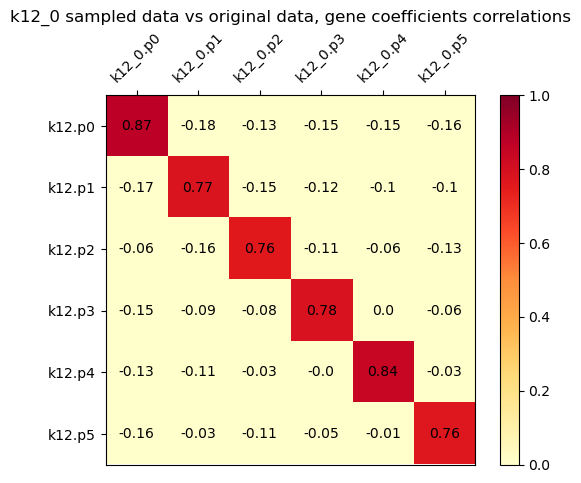

In [46]:
concatenated_spectras = pd.concat([orig_ns.data_gene_coefs[subdata.var.highly_variable],
                                   orig_ns.gene_coefs__pfnmf[0]], axis=1)

n_genes, n_programs = concatenated_spectras.shape

ranked_coefs = n_genes - rankdata(concatenated_spectras, axis=0)

ranked_coefs[ranked_coefs > 400] = 400

spearman_corr = np.corrcoef(ranked_coefs, rowvar=False)

ax = _utils.heatmap_with_numbers(
    spearman_corr[:orig_ns.rank, orig_ns.rank:],
    title=f'{orig_ns.name} sampled data vs original data, gene coefficients correlations', param_dict={'vmin': 0, 'vmax': 1})

ax.set_xticks(ticks=ax.get_xticks(), labels=orig_ns.nmf_prog_names)
ax.set_yticks(ticks=ax.get_yticks(), labels=orig_ns.data_prog_names)
ax.tick_params(axis='x', labelrotation = 45)

plt.show()
plt.close()

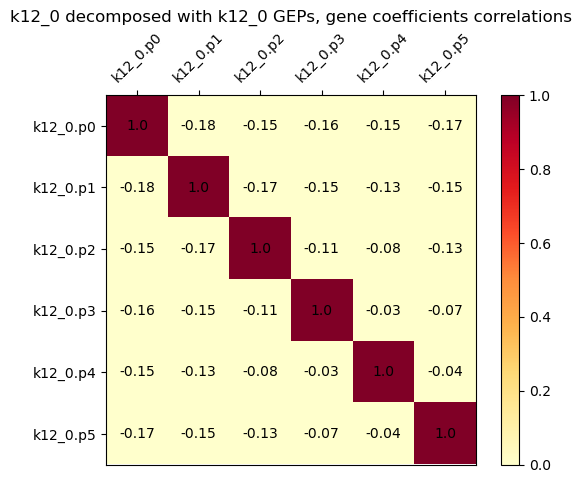

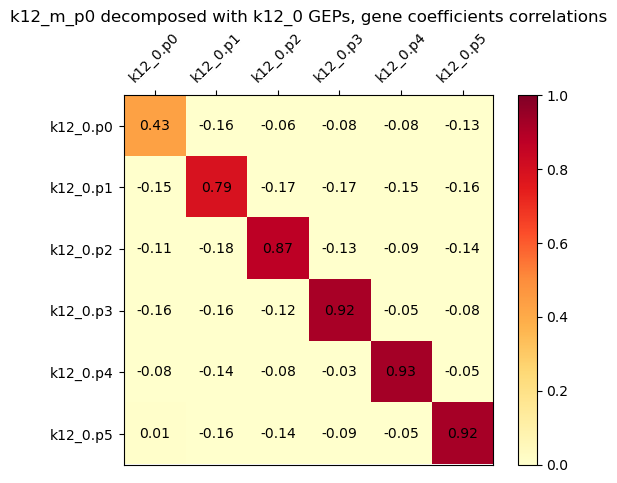

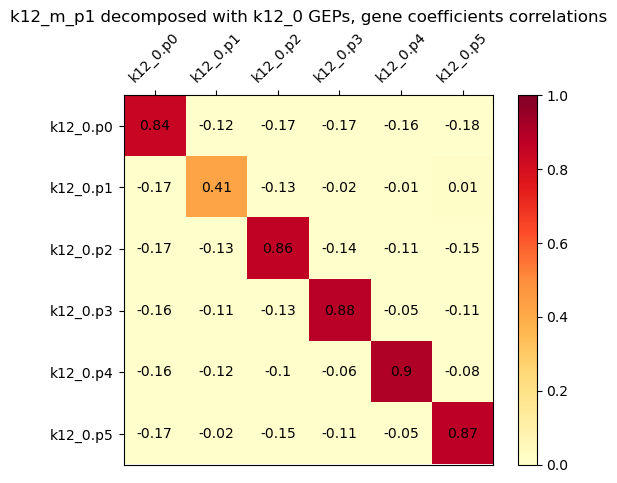

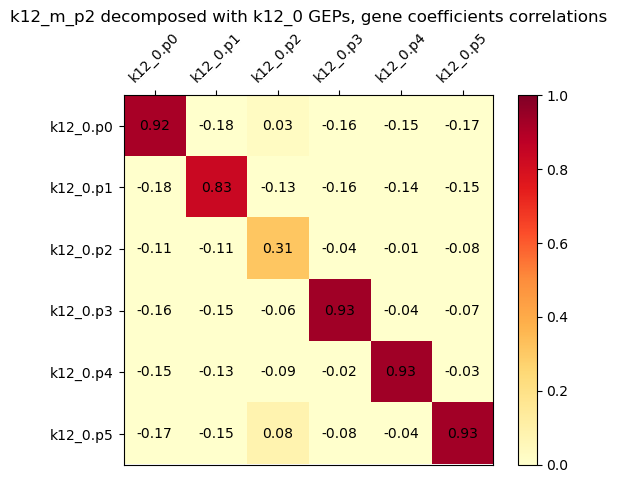

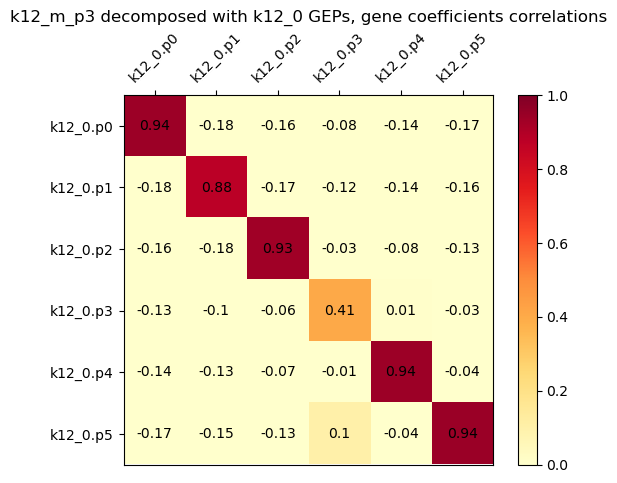

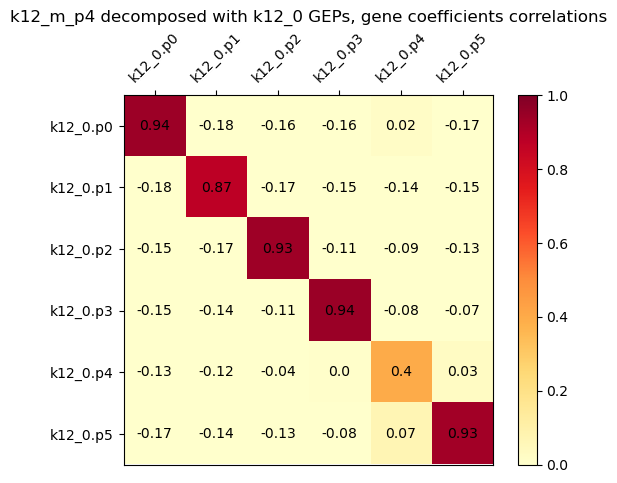

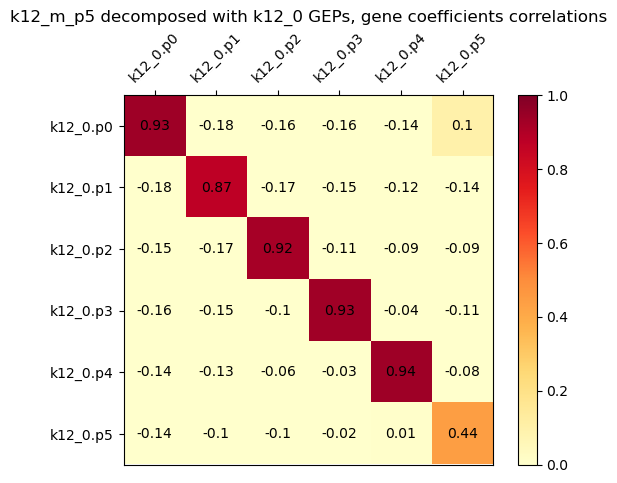

In [47]:
n_coefs = 400

for name, ns in recompositions.items():
    
    concatenated_spectras = pd.concat([orig_ns.gene_coefs__pfnmf[0],
                                       ns.gene_coefs__pfnmf[0]], axis=1)

    n_genes, n_programs = concatenated_spectras.shape

    ranked_coefs = n_genes - rankdata(concatenated_spectras, axis=0)
    
    ranked_coefs[ranked_coefs > n_coefs] = n_coefs
    
    spearman_corr = np.corrcoef(ranked_coefs, rowvar=False)
    
    ax = _utils.heatmap_with_numbers(
        spearman_corr[:orig_ns.rank, orig_ns.rank:],
        title=f'{name} decomposed with k12_0 GEPs, gene coefficients correlations', param_dict={'vmin': 0, 'vmax': 1})

    ax.set_xticks(ticks=ax.get_xticks(), labels=orig_ns.nmf_prog_names)
    ax.set_yticks(ticks=ax.get_yticks(), labels=orig_ns.nmf_prog_names)
    ax.tick_params(axis='x', labelrotation = 45)

    plt.show()
    plt.close()

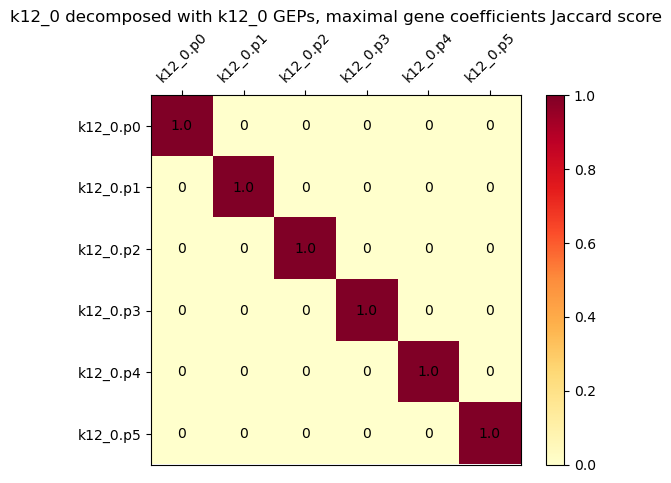

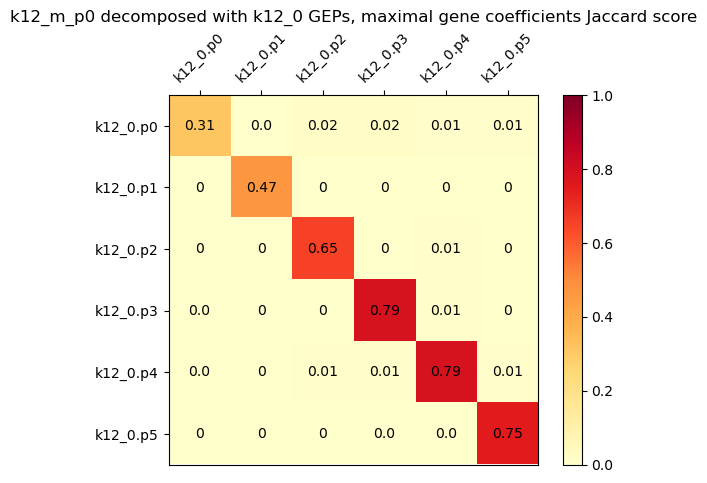

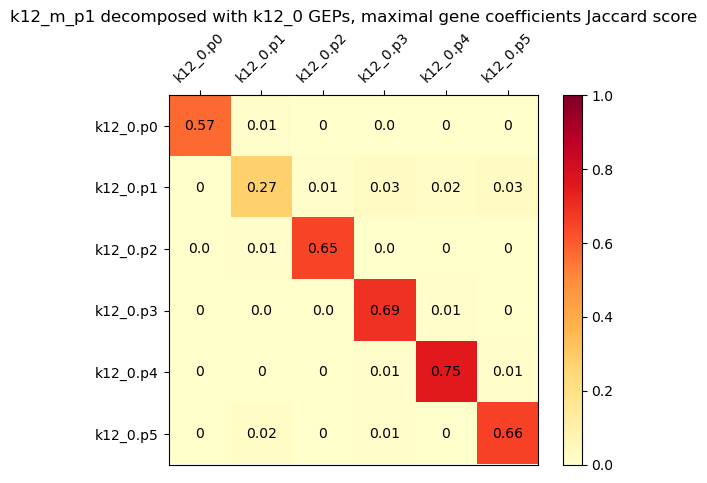

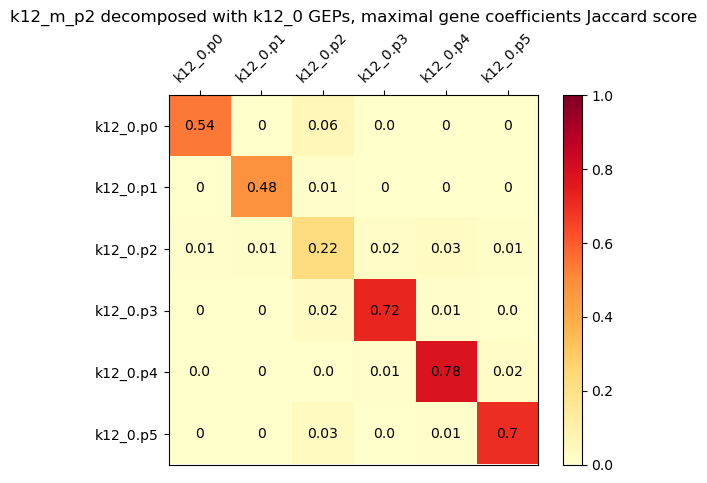

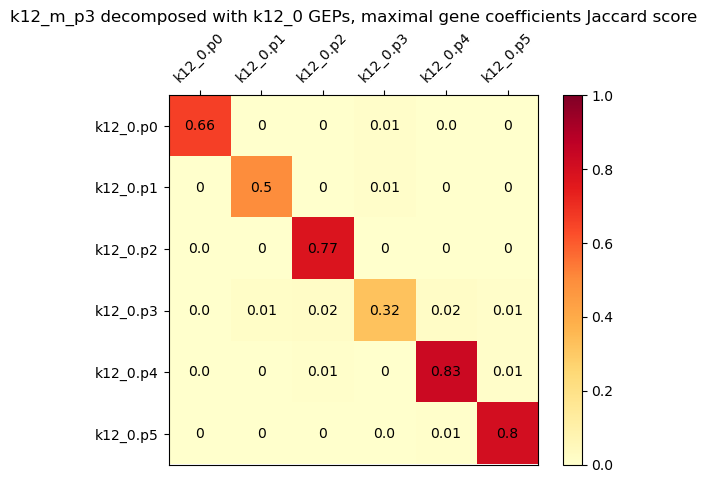

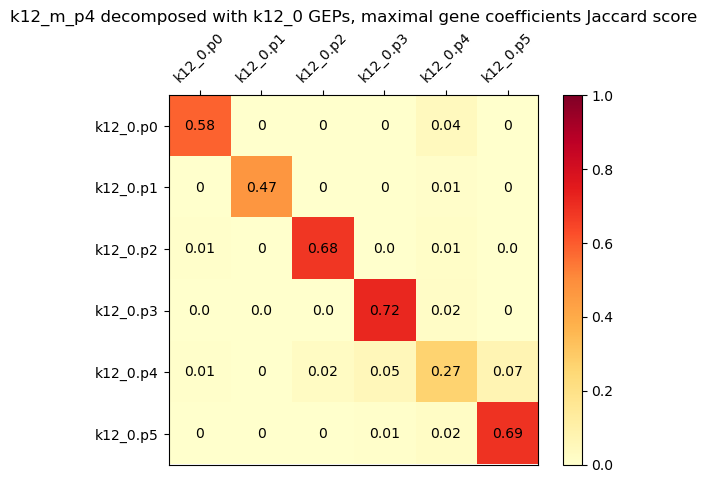

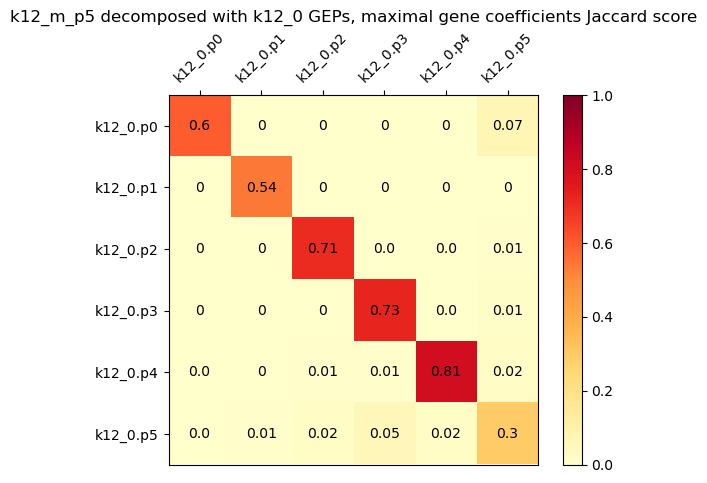

In [48]:
# Calculating jaccard scores on top 10% (200) of coefficients.
n_coefs = 200

maxvals_orig = orig_ns.gene_coefs__pfnmf[0] >= orig_ns.gene_coefs__pfnmf[0].values.max(axis=1, keepdims=True)

for name, ns in recompositions.items():
    maxvals_ns = ns.gene_coefs__pfnmf[0] >= ns.gene_coefs__pfnmf[0].values.max(axis=1, keepdims=True)
    
    concatenated_maxvals = pd.concat([maxvals_orig, maxvals_ns], axis=1)
    
    n_genes, n_programs = concatenated_maxvals.shape
    
    concatenated_spectras = pd.concat([orig_ns.gene_coefs__pfnmf[0],
                                       ns.gene_coefs__pfnmf[0]], axis=1)
    ranked_coefs = n_genes - rankdata(concatenated_spectras, axis=0)
    
    jaccard_scores = _utils.df_jaccard_score(concatenated_maxvals & (ranked_coefs < n_coefs))
    
    ax = _utils.heatmap_with_numbers(
        jaccard_scores[:orig_ns.rank, orig_ns.rank:],
        title=f'{name} decomposed with k12_0 GEPs, maximal gene coefficients Jaccard score', param_dict={'vmin': 0, 'vmax': 1})

    ax.set_xticks(ticks=ax.get_xticks(), labels=orig_ns.nmf_prog_names)
    ax.set_yticks(ticks=ax.get_yticks(), labels=orig_ns.nmf_prog_names)
    ax.tick_params(axis='x', labelrotation = 45)

    plt.show()
    plt.close()

### 8. Perform decomposition of K12_0 using K12_m_p[#] GEPs (gain of GEP operator) 

In [27]:
#  k12_0.data ~ W @ k12_m_p[].H_nmf

for name, ns in recompositions.items():
    print('working on ', ns.name)
    
    nmf_kwargs={'H': ns.H_nmf.copy(),
                'update_H': False,
                'tol': _constants.NMF_TOLERANCE,
                'max_iter': max_iter,
                'beta_loss': beta_loss
               }
    
    tens = torch.tensor(orig_ns.data).to(device)
    W, H, n_iter = cnmf.nmf_torch(orig_ns.data, nmf_kwargs, tens, verbose=True)
    del tens

    ns.gain_pfnmf_error = []
    ns.gain_pfnmf_error.append(sknmf._beta_divergence(orig_ns.data, W, H, beta_loss) / subdata.n_obs)
    print(f'Error per sample = {ns.gain_pfnmf_error[-1]: .1f}')

    ns.gain_pfnmf_loss_per_cell = pfnmf.calc_beta_divergence(orig_ns.data.T, H.T, np.zeros((H.shape[1], 0)), W.T, np.zeros((0, W.shape[0])), per_column=True)
    
    ns.W_gain_pfnmf = []
    ns.W_gain_pfnmf.append(W)
    
    print()

working on  k12_0
beta 1 loss = 201462.046875, # iterations was 60
Error per sample =  442.8

working on  k12_m_p0
beta 1 loss = 272572.75, # iterations was 50
Error per sample =  599.1

working on  k12_m_p1
beta 1 loss = 253373.078125, # iterations was 50
Error per sample =  556.9

working on  k12_m_p2
beta 1 loss = 230722.21875, # iterations was 50
Error per sample =  507.1

working on  k12_m_p3
beta 1 loss = 225880.0, # iterations was 60
Error per sample =  496.4

working on  k12_m_p4
beta 1 loss = 221406.390625, # iterations was 60
Error per sample =  486.6

working on  k12_m_p5
beta 1 loss = 222596.625, # iterations was 60
Error per sample =  489.2



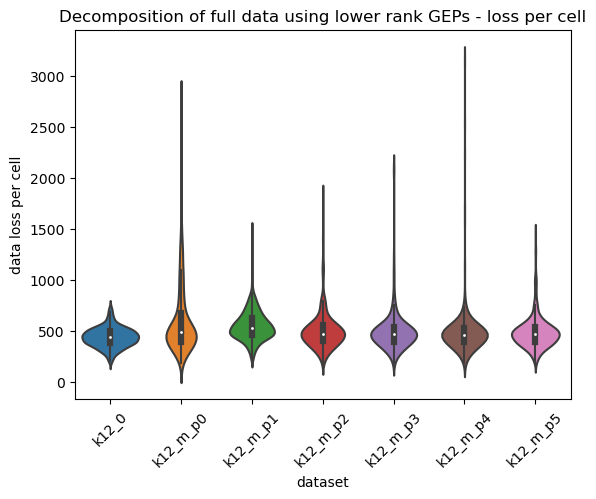

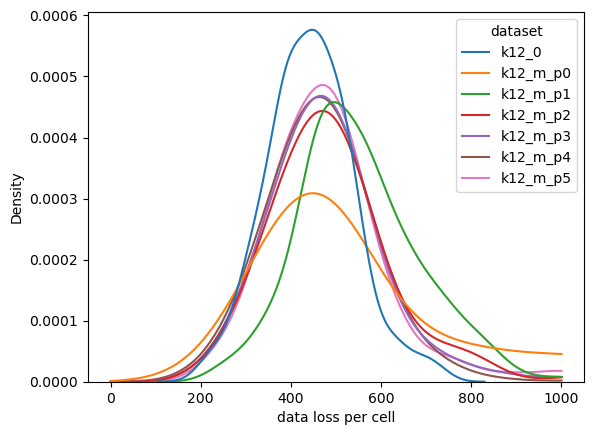

In [78]:

df = pd.concat([pd.Series(ns.gain_pfnmf_loss_per_cell, name=name) for name, ns in recompositions.items()], axis=1)
df = pd.melt(df, var_name='dataset', value_name='data loss per cell')

_utils.sns.violinplot(data=df, x="dataset", y="data loss per cell")

plt.title('Decomposition of full data using lower rank GEPs - loss per cell')
plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.show()
plt.close()

_utils.sns.kdeplot(df, hue="dataset", x="data loss per cell", clip=(0, 1000))
plt.show()

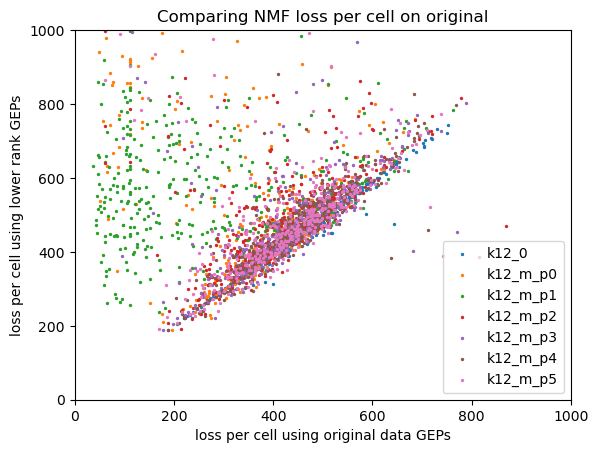

In [29]:
for name, ns in recompositions.items():
    plt.scatter(ns.pfnmf0_loss_per_cell, ns.gain_pfnmf_loss_per_cell, label=name, s=2)

plt.title('Comparing NMF loss per cell on original')

plt.xlabel('loss per cell using original data GEPs')
plt.xlim((0, 1000))

plt.ylabel('loss per cell using lower rank GEPs')
plt.ylim((0, 1000))
plt.legend()
plt.show()

#### usages comparisons
Results: other GEPs seem to "take charge" of cells that were primarily using a dropped GEP

working on  k12_0


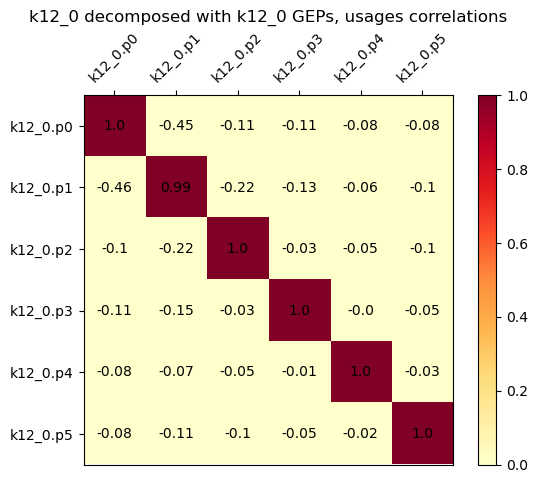

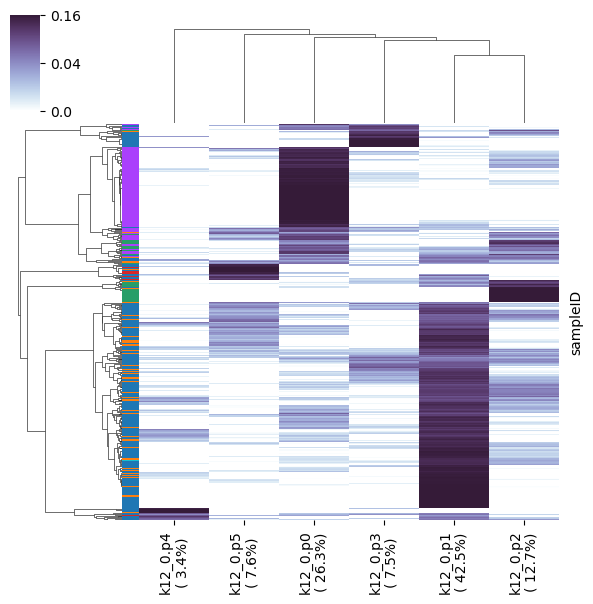

working on  k12_m_p0


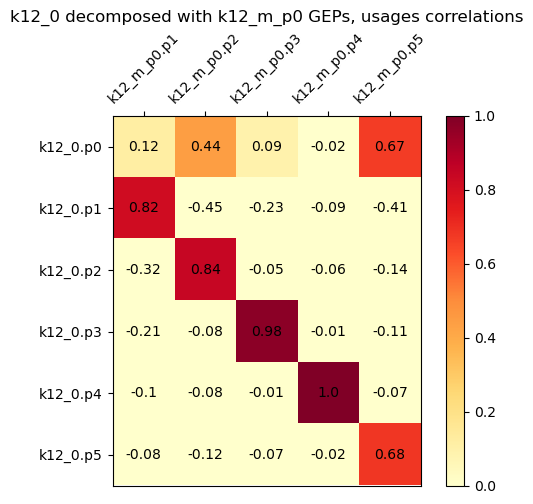

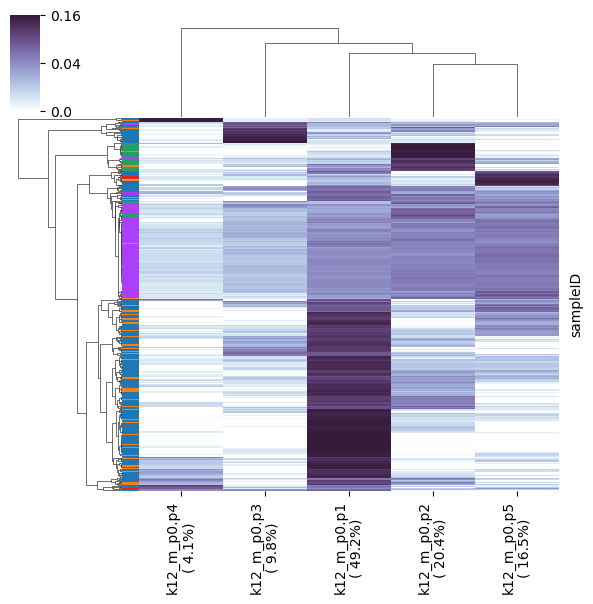

working on  k12_m_p1


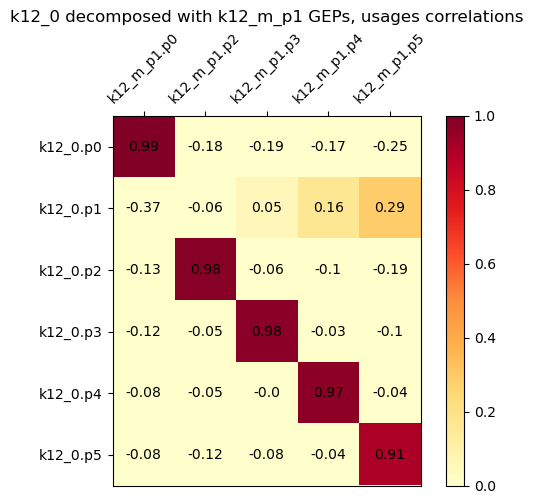

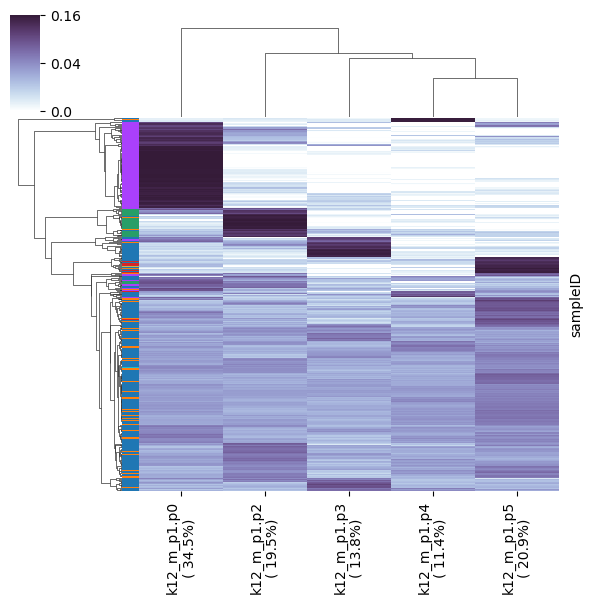

working on  k12_m_p2


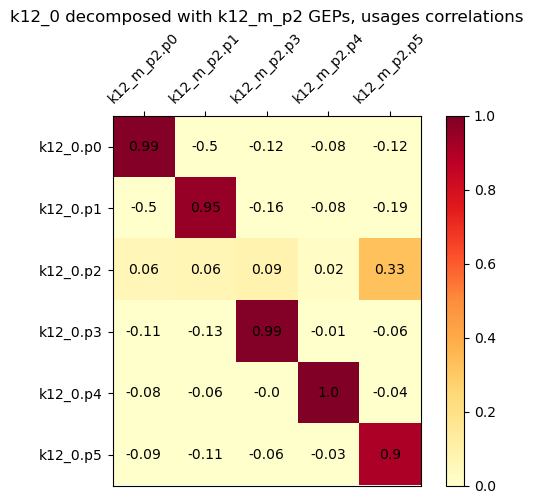

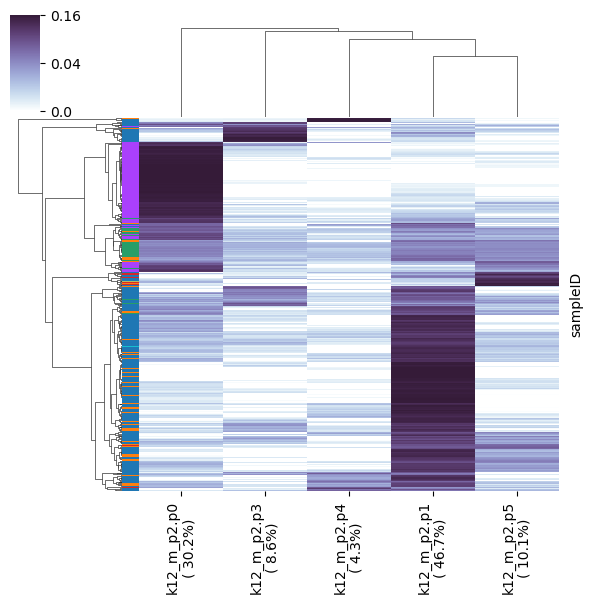

working on  k12_m_p3


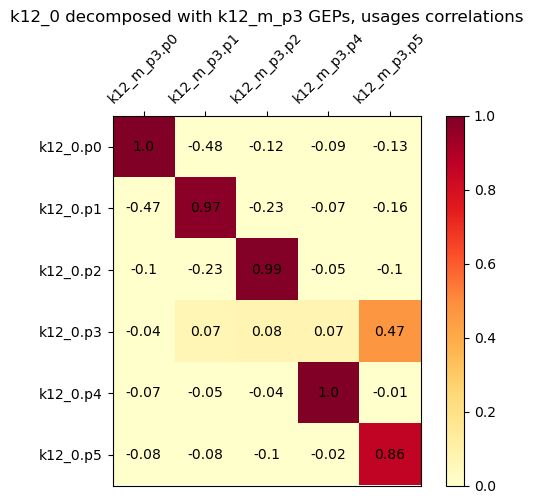

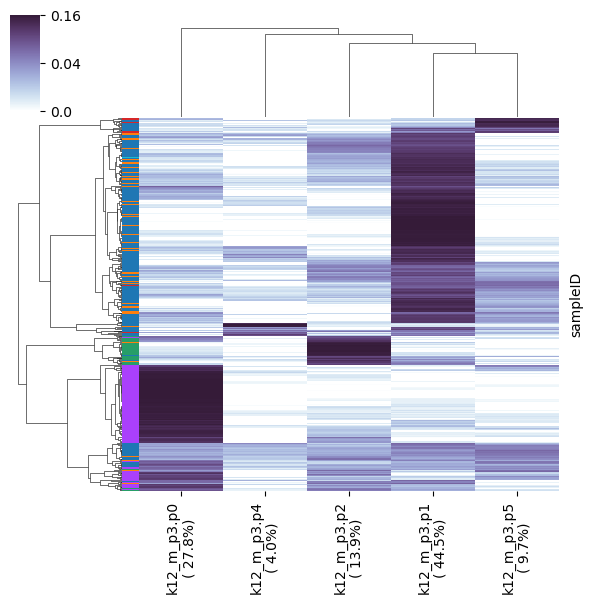

working on  k12_m_p4


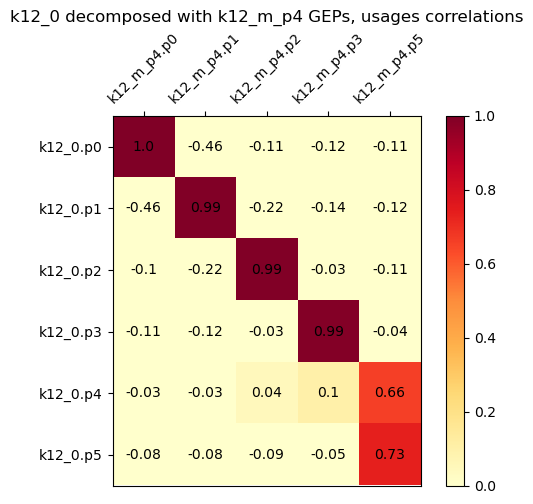

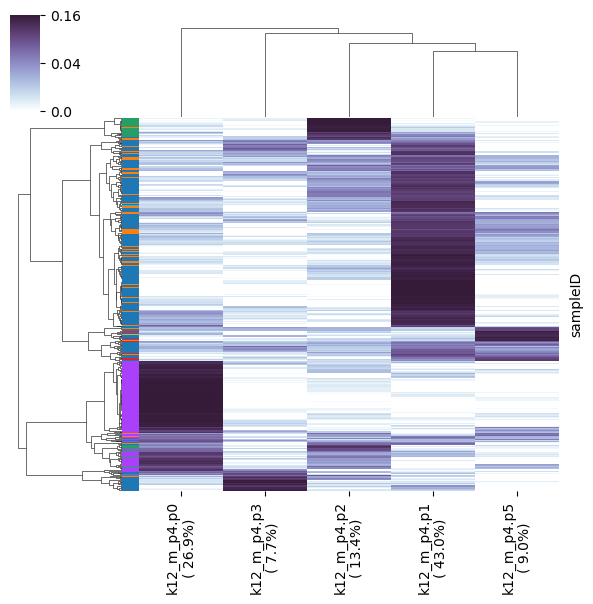

working on  k12_m_p5


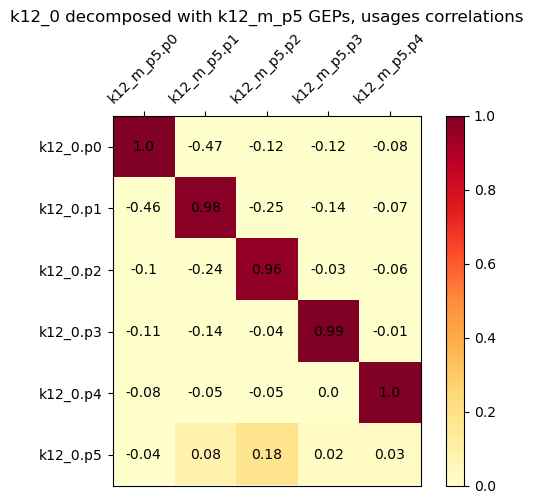

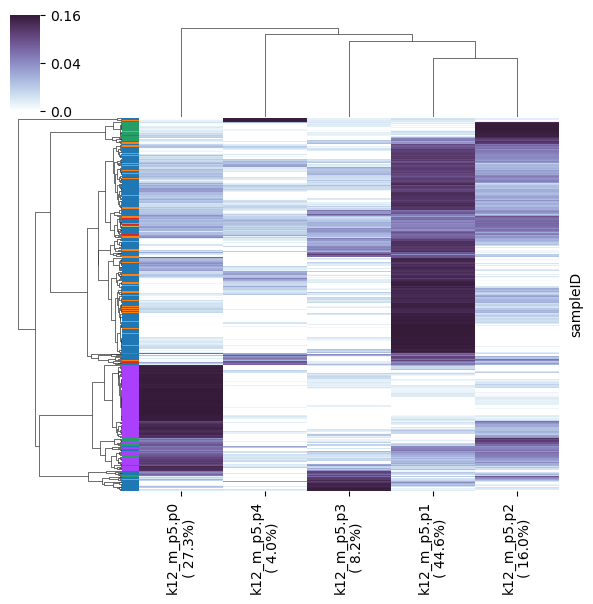

In [30]:
for name, ns in recompositions.items():
    print('working on ', ns.name)
        
    ax = _utils.heatmap_with_numbers(
        np.corrcoef(orig_ns.W.T, ns.W_gain_pfnmf[0].T)[:orig_ns.rank, orig_ns.rank:],
        title=f'k12_0 decomposed with {name} GEPs, usages correlations', param_dict={'vmin': 0, 'vmax': 1})

    ax.set_xticks(ticks=ax.get_xticks(), labels=ns.nmf_prog_names)
    ax.set_yticks(ticks=ax.get_yticks(), labels=orig_ns.nmf_prog_names)
    ax.tick_params(axis='x', labelrotation = 45)

    plt.show()
    plt.close()

    
    title = f'k12_0 decomposed with {name} GEPs, normalized usages'

    eps_W = ns.W_gain_pfnmf[0] + np.finfo(float).eps**2
    normalized_usages = (eps_W  / (eps_W.sum(axis=1, keepdims=True)))
    normalized_usages[eps_W.sum(axis=1) < np.finfo(float).eps] = np.finfo(float).eps**2

    prog_percent = normalized_usages.sum(axis=0) * 100 / subdata.n_obs
    prog_label_2l = [name + f'\n({prog_percent[i]: 0.1f}%)' for i, name in enumerate(ns.nmf_prog_names)]

    un_sns = _utils.plot_usages_norm_clustermaps(subdata, normalized_usages=normalized_usages,
        columns=prog_label_2l, title='', show=True, sns_clustermap_params={'figsize':(6, 6)})

    plt.close(un_sns.figure)

#### Gene coefficients comparison
Results: some low correlation arrives from the GEP that is used to "cover" for the dropped one

In [31]:
# Extracting gene coefficients from resampled data:

obs_mask = orig_ns.data.sum(axis=1)!=0
var_mask = orig_ns.data.std(axis=0)!=0

data = orig_ns.data.copy()[obs_mask]
data *= (500 / data.sum(axis=1, keepdims=True))
np.log1p(data, out=data)
data -= data.mean(axis=0, keepdims=True)

data[:, var_mask] /= data[:, var_mask].std(axis=0, keepdims=True) 

for name, ns in recompositions.items():  
    
    # not perfectly sound, but OK for now
    eps_W = ns.W_gain_pfnmf[0][obs_mask] + np.finfo(float).eps**2
    normalized_usages = (eps_W  / (eps_W.sum(axis=1, keepdims=True)))
    normalized_usages[eps_W.sum(axis=1) < np.finfo(float).eps] = np.finfo(float).eps**2

    ns.gene_coefs_gain_pfnmf = []
    ns.gene_coefs_gain_pfnmf.append(pd.DataFrame(
        _utils.fastols(normalized_usages, data).T,
        index=subdata.var[subdata.var.highly_variable].index,
        columns=ns.nmf_prog_names))

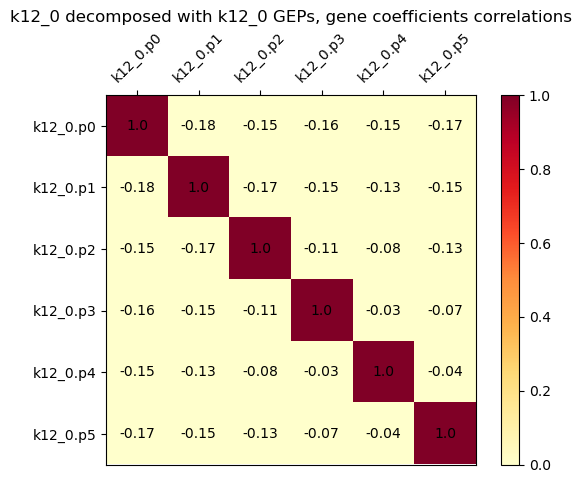

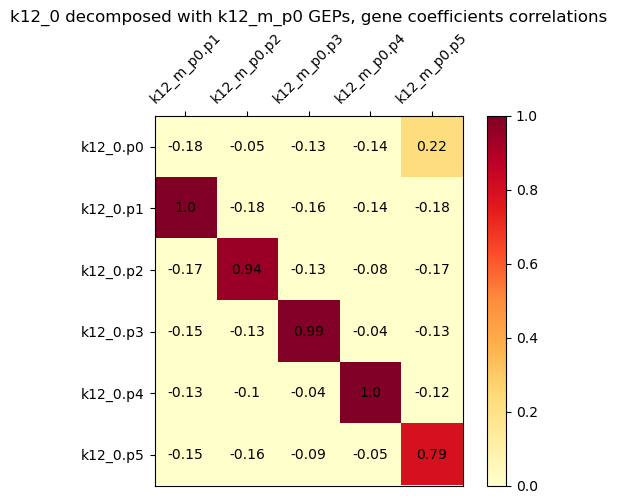

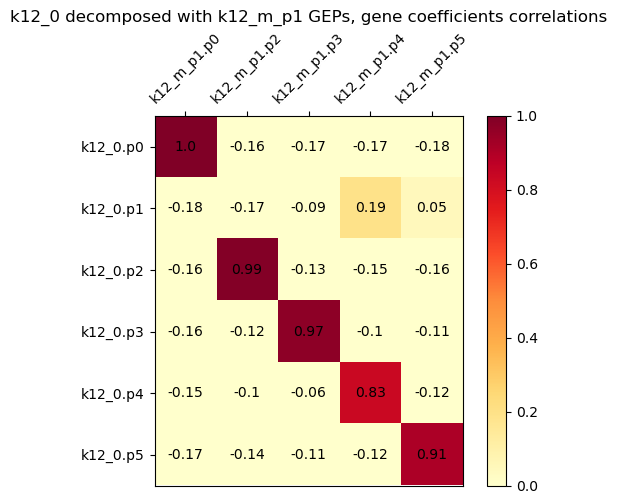

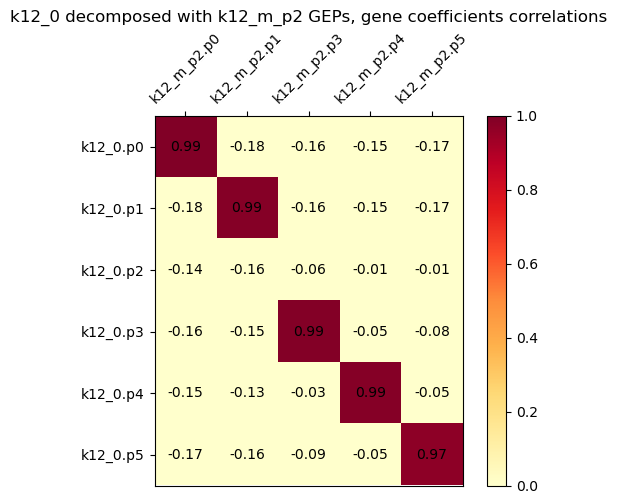

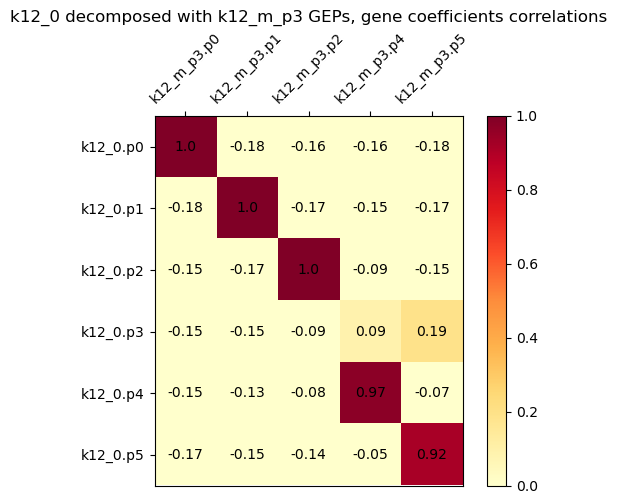

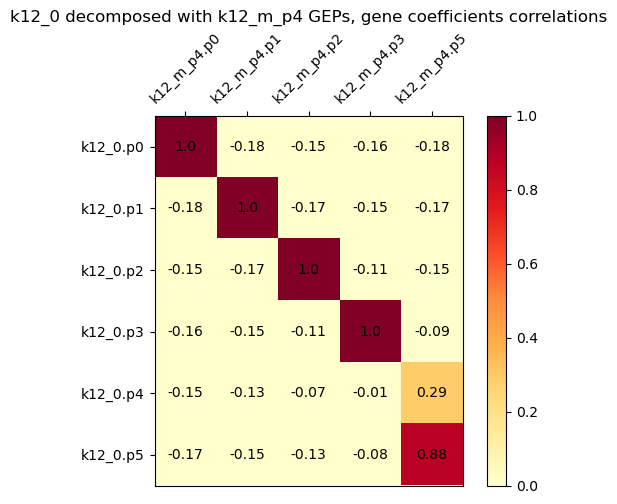

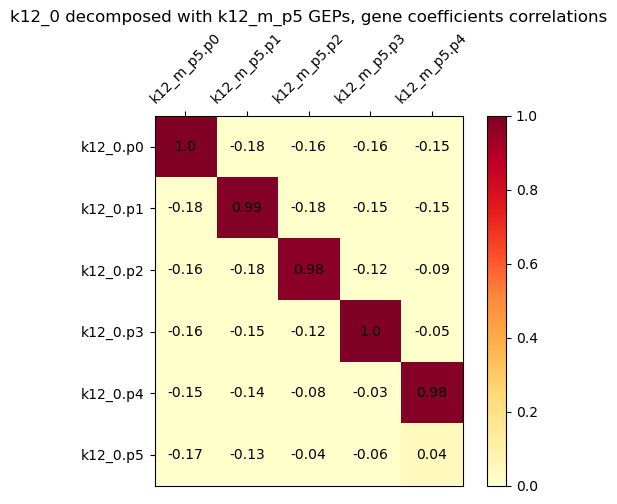

In [32]:
n_coefs = 400

for name, ns in recompositions.items():
    
    concatenated_spectras = pd.concat([orig_ns.gene_coefs_gain_pfnmf[0],
                                       ns.gene_coefs_gain_pfnmf[0]], axis=1)

    n_genes, n_programs = concatenated_spectras.shape

    ranked_coefs = n_genes - rankdata(concatenated_spectras, axis=0)
    
    ranked_coefs[ranked_coefs > n_coefs] = n_coefs
    
    spearman_corr = np.corrcoef(ranked_coefs, rowvar=False)
    
    ax = _utils.heatmap_with_numbers(
        spearman_corr[:orig_ns.rank, orig_ns.rank:],
        title=f'k12_0 decomposed with {name} GEPs, gene coefficients correlations', param_dict={'vmin': 0, 'vmax': 1})

    ax.set_xticks(ticks=ax.get_xticks(), labels=ns.nmf_prog_names)
    ax.set_yticks(ticks=ax.get_yticks(), labels=orig_ns.nmf_prog_names)
    ax.tick_params(axis='x', labelrotation = 45)

    plt.show()
    plt.close()

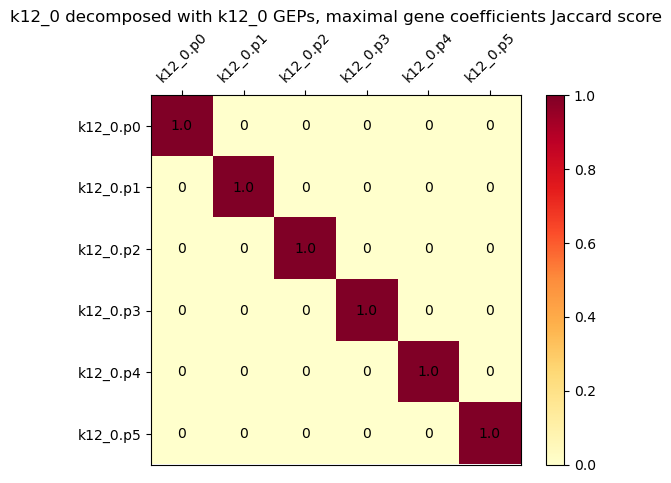

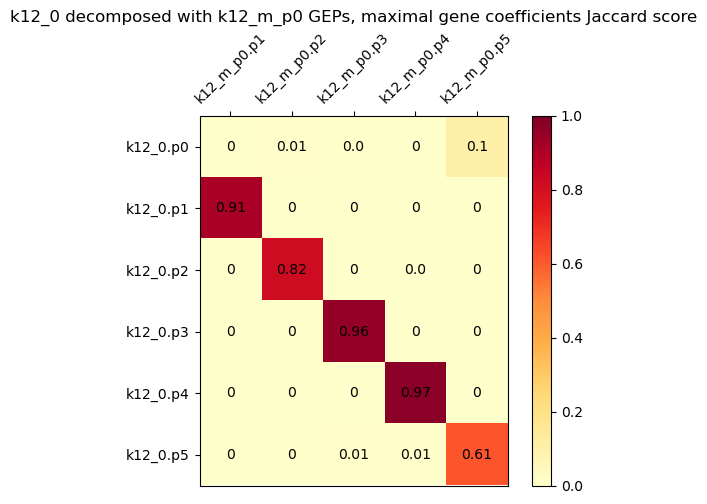

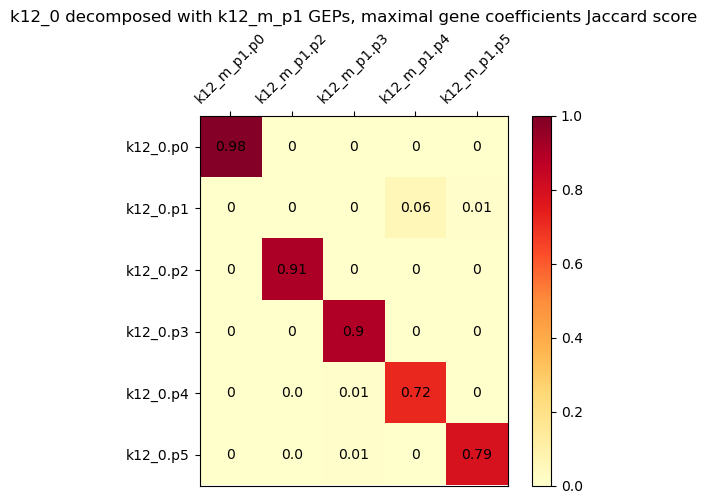

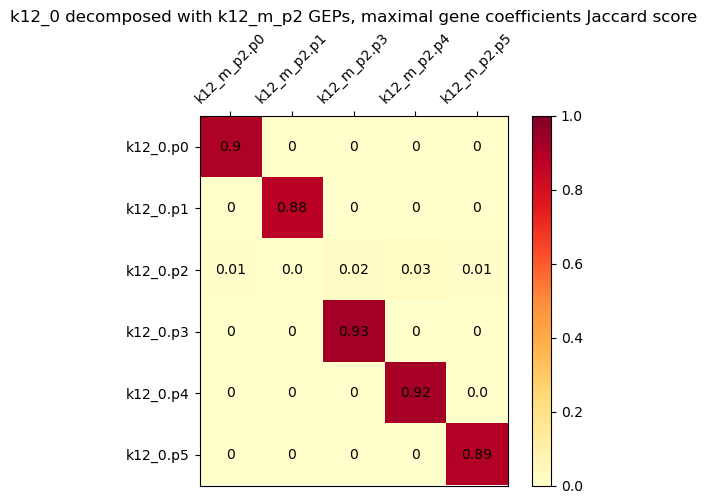

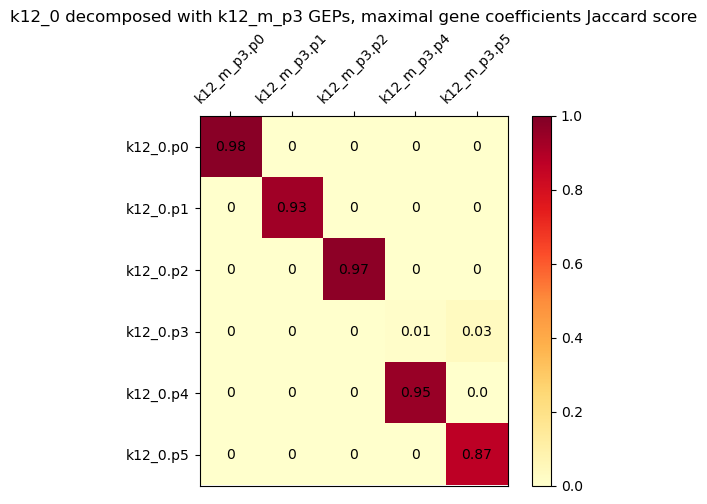

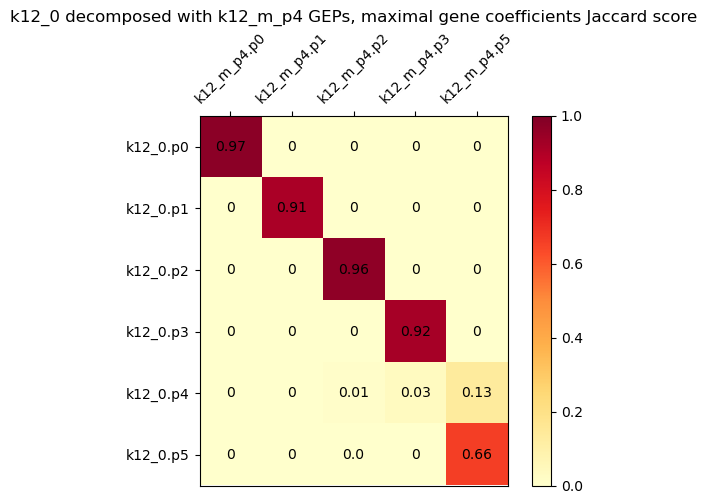

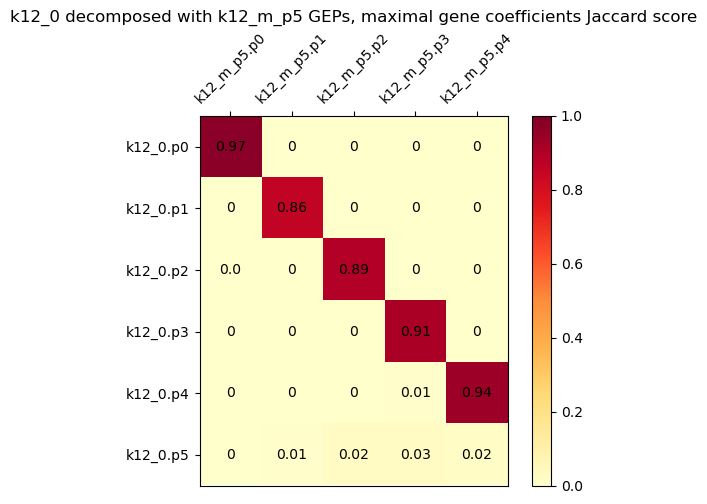

In [33]:
# Calculating jaccard scores on top 10% (200) of coefficients.
n_coefs = 200

maxvals_orig = orig_ns.gene_coefs_gain_pfnmf[0] >= orig_ns.gene_coefs_gain_pfnmf[0].values.max(axis=1, keepdims=True)

for name, ns in recompositions.items():
    maxvals_ns = ns.gene_coefs_gain_pfnmf[0] >= ns.gene_coefs_gain_pfnmf[0].values.max(axis=1, keepdims=True)
    
    concatenated_maxvals = pd.concat([maxvals_orig, maxvals_ns], axis=1)
    
    n_genes, n_programs = concatenated_maxvals.shape
    
    concatenated_spectras = pd.concat([orig_ns.gene_coefs_gain_pfnmf[0],
                                       ns.gene_coefs_gain_pfnmf[0]], axis=1)
    ranked_coefs = n_genes - rankdata(concatenated_spectras, axis=0)
    
    jaccard_scores = _utils.df_jaccard_score(concatenated_maxvals & (ranked_coefs < n_coefs))
    
    ax = _utils.heatmap_with_numbers(
        jaccard_scores[:orig_ns.rank, orig_ns.rank:],
        title=f'k12_0 decomposed with {name} GEPs, maximal gene coefficients Jaccard score', param_dict={'vmin': 0, 'vmax': 1})

    ax.set_xticks(ticks=ax.get_xticks(), labels=ns.nmf_prog_names)
    ax.set_yticks(ticks=ax.get_yticks(), labels=orig_ns.nmf_prog_names)
    ax.tick_params(axis='x', labelrotation = 45)

    plt.show()
    plt.close()

### 9. Perform pfnmf with 1, 2, 3 extra GEPs of K12_m_p[#] using K12_0 GEPs (loss of GEP operator)
Results: as expected, additional degrees of freedom add little to the final loss

In [34]:
# %%script --no-raise-error false

# pfnmf is written for constant W_1, so we will transpose as needed:
# K12_m_p[#] ~ W_1 @ k12_0.H + W_2 @ H_2  <--> K12_m_p[#].T ~ k12_0.H.T @ W_1.T + H_2.T @ W_2.T

pfnmf_repeats = 3

for name, ns in recompositions.items():
    print('working on ', ns.name, f'original loss was {ns.pfnmf_error[0]: .1f}' )
    ns.pfnmf = [0, 1, 2, 3]
    
    if len(ns.pfnmf_error) == 1:
        ns.pfnmf_error.extend([1, 2, 3])
    
    
    for added_rank in [1, 2, 3]:
        print(f"Working on added rank = {added_rank}")

        best_loss = np.infty
        
        for repeat in range(pfnmf_repeats):
            X = ns.data.T
            X[:, (X.sum(axis=0)==0)] += np.finfo(float).eps
            X[(X.sum(axis=1)==0), :] += np.finfo(float).eps
            
            w1, h1, w2, h2, n_iter = pfnmf.pfnmf(
                X, orig_ns.H_nmf.T, rank_2=added_rank, beta_loss=beta_loss,
                tol=_constants.NMF_TOLERANCE, max_iter=max_iter, verbose=False)

            final_loss = pfnmf.calc_beta_divergence(X, w1, w2, h1, h2, beta_loss)

            if final_loss <= best_loss:
                best_loss = final_loss
                ns.pfnmf[added_rank] = {'w1': w1, 'h1': h1, 'w2': w2, 'h2': h2, 'n_iter': n_iter}
                ns.pfnmf_error[added_rank] = final_loss / subdata.n_obs

                print(f"repeat {repeat}, after {n_iter} iterations reached {final_loss: .4e}"
                     f", per sample loss = {ns.pfnmf_error[added_rank]: .1f}")
    print()

working on  k12_0 original loss was  451.4
Working on added rank = 1
repeat 0, after 90 iterations reached  2.0058e+05, per sample loss =  440.8
repeat 1, after 116 iterations reached  2.0054e+05, per sample loss =  440.7
Working on added rank = 2
repeat 0, after 103 iterations reached  1.9972e+05, per sample loss =  438.9
repeat 1, after 140 iterations reached  1.9970e+05, per sample loss =  438.9
repeat 2, after 118 iterations reached  1.9956e+05, per sample loss =  438.6
Working on added rank = 3
repeat 0, after 132 iterations reached  1.9894e+05, per sample loss =  437.2
repeat 1, after 132 iterations reached  1.9888e+05, per sample loss =  437.1
repeat 2, after 141 iterations reached  1.9874e+05, per sample loss =  436.8

working on  k12_m_p0 original loss was  346.7
Working on added rank = 1
repeat 0, after 126 iterations reached  1.5683e+05, per sample loss =  344.7
repeat 1, after 68 iterations reached  1.5680e+05, per sample loss =  344.6
Working on added rank = 2
repeat 0, af

### 10. Perform pfnmf on K12_0 using K12_m_p[#] GEPs with 1, 2, 3 extra GEPs (gain of GEP operator)
Results: after adding just one more GEP we get similar loss to the baseline

In [35]:
# %%script --no-raise-error false

# pfnmf is written for constant W_1, so we will transpose as needed:
# k12_0 ~ W_1 @ K12_m_p[#].H_nmf + W_2 @ H_2  <--> k12_0.T ~ K12_m_p[#].H_nmf.T @ W_1.T + H_2.T @ W_2.T

pfnmf_repeats = 5

X = orig_ns.data.T
X[:, (X.sum(axis=0)==0)] += np.finfo(float).eps
X[(X.sum(axis=1)==0), :] += np.finfo(float).eps

for name, ns in recompositions.items():
    print('working on ', ns.name, f', original loss was {ns.gain_pfnmf_error[0]: .1f}')
    ns.gain_pfnmf = [0, 1, 2, 3]
    
    if len(ns.gain_pfnmf_error) == 1:
        ns.gain_pfnmf_error.extend([1, 2, 3])
    
    
    for added_rank in [1, 2, 3]:
        print(f"Working on added rank = {added_rank}")

        best_loss = np.infty
        
        for repeat in range(pfnmf_repeats):
            w1, h1, w2, h2, n_iter = pfnmf.pfnmf(
                X, ns.H_nmf.T, rank_2=added_rank, beta_loss=beta_loss,
                tol=_constants.NMF_TOLERANCE, max_iter=max_iter, verbose=False)

            final_loss = pfnmf.calc_beta_divergence(X, w1, w2, h1, h2, beta_loss)

            if final_loss <= best_loss:
                best_loss = final_loss
                ns.gain_pfnmf[added_rank] = {'w1': w1, 'h1': h1, 'w2': w2, 'h2': h2, 'n_iter': n_iter}
                ns.gain_pfnmf_error[added_rank] = final_loss / subdata.n_obs

                print(f"repeat {repeat}, after {n_iter} iterations reached {final_loss: .4e}"
                     f", per sample loss = {ns.gain_pfnmf_error[added_rank]: .1f}")
    print()

working on  k12_0 , original loss was  442.8
Working on added rank = 1
repeat 0, after 113 iterations reached  2.0055e+05, per sample loss =  440.8
repeat 3, after 97 iterations reached  2.0053e+05, per sample loss =  440.7
Working on added rank = 2
repeat 0, after 118 iterations reached  1.9969e+05, per sample loss =  438.9
repeat 4, after 136 iterations reached  1.9965e+05, per sample loss =  438.8
Working on added rank = 3
repeat 0, after 148 iterations reached  1.9882e+05, per sample loss =  437.0
repeat 1, after 176 iterations reached  1.9879e+05, per sample loss =  436.9
repeat 3, after 143 iterations reached  1.9875e+05, per sample loss =  436.8

working on  k12_m_p0 , original loss was  599.1
Working on added rank = 1
repeat 0, after 37 iterations reached  2.0888e+05, per sample loss =  459.1
repeat 2, after 37 iterations reached  2.0888e+05, per sample loss =  459.1
Working on added rank = 2
repeat 0, after 102 iterations reached  2.0776e+05, per sample loss =  456.6
repeat 1,

In [36]:
added_rank = 1

for name, ns in recompositions.items():
    ns.pfnmf1_loss_per_cell = pfnmf.calc_beta_divergence(
        X, ns.gain_pfnmf[added_rank]['w1'], ns.gain_pfnmf[added_rank]['w2'],
        ns.gain_pfnmf[added_rank]['h1'], ns.gain_pfnmf[added_rank]['h2'], beta_loss, per_column=True)


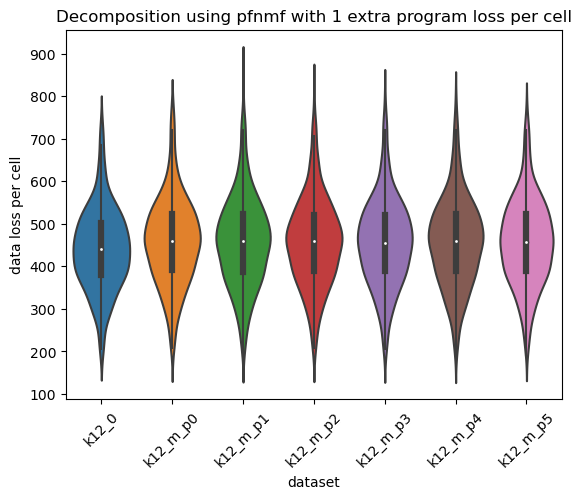

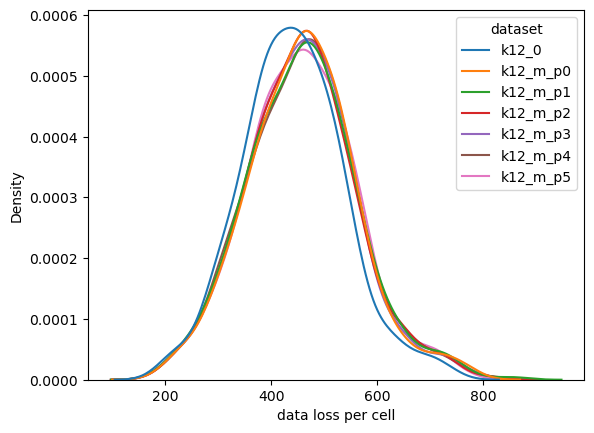

In [37]:

df = pd.concat([pd.Series(ns.pfnmf1_loss_per_cell, name=name) for name, ns in recompositions.items()], axis=1)
df = pd.melt(df, var_name='dataset', value_name='data loss per cell')

_utils.sns.violinplot(data=df, x="dataset", y="data loss per cell")

plt.title('Decomposition using pfnmf with 1 extra program loss per cell')
plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.show()
plt.close()

_utils.sns.kdeplot(df, hue="dataset", x="data loss per cell", clip=(0, 1000))
plt.show()

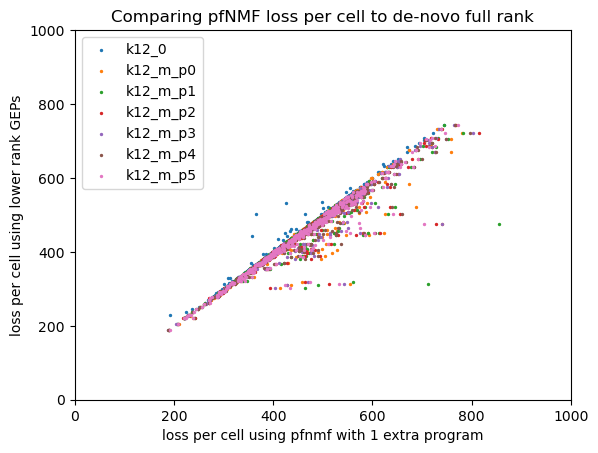

In [38]:
for name, ns in recompositions.items():
    plt.scatter(ns.pfnmf1_loss_per_cell, orig_ns.nmf_loss_per_cell, label=name, s=2)

plt.title('Comparing pfNMF loss per cell to de-novo full rank')

plt.xlabel('loss per cell using pfnmf with 1 extra program')
plt.xlim((0, 1000))

plt.ylabel('loss per cell using lower rank GEPs')
plt.ylim((0, 1000))
plt.legend()
plt.show()

#### Gene coefficients

In [57]:
# Extracting gene coefficients from resampled data:

obs_mask = orig_ns.data.sum(axis=1)!=0
var_mask = orig_ns.data.std(axis=0)!=0

data = orig_ns.data.copy()[obs_mask]
data *= (500 / data.sum(axis=1, keepdims=True))
np.log1p(data, out=data)
data -= data.mean(axis=0, keepdims=True)

data[:, var_mask] /= data[:, var_mask].std(axis=0, keepdims=True) 

for name, ns in recompositions.items():  
    # not perfectly sound, but OK for now
    h1 = ns.gain_pfnmf[1]['h1'].T[obs_mask]
    h2 = ns.gain_pfnmf[1]['h2'].T[obs_mask]
    
    eps_W = np.concatenate([h1, h2], axis=1) + np.finfo(float).eps**2
    normalized_usages = (eps_W  / (eps_W.sum(axis=1, keepdims=True)))
    normalized_usages[eps_W.sum(axis=1) < np.finfo(float).eps] = np.finfo(float).eps**2

    coefs = pd.DataFrame(
        _utils.fastols(normalized_usages, data).T,
        index=subdata.var[subdata.var.highly_variable].index,
        columns=[*ns.nmf_prog_names, ns.name+'.e1'])
    
    if len(ns.gene_coefs__pfnmf) == 1:
        ns.gene_coefs__pfnmf.append(coefs)
    else:
        ns.gene_coefs__pfnmf[1] = coefs

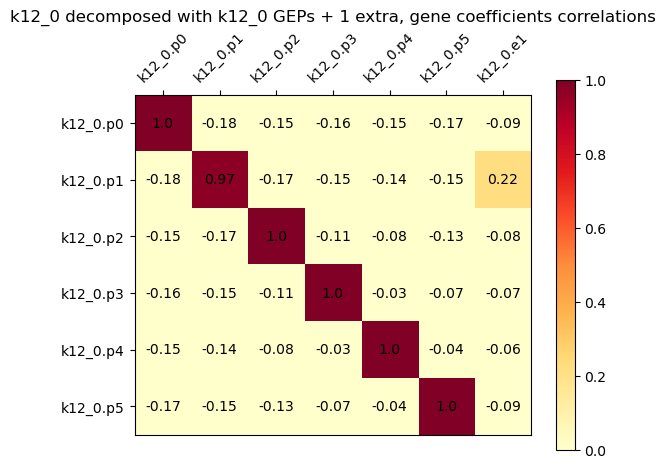

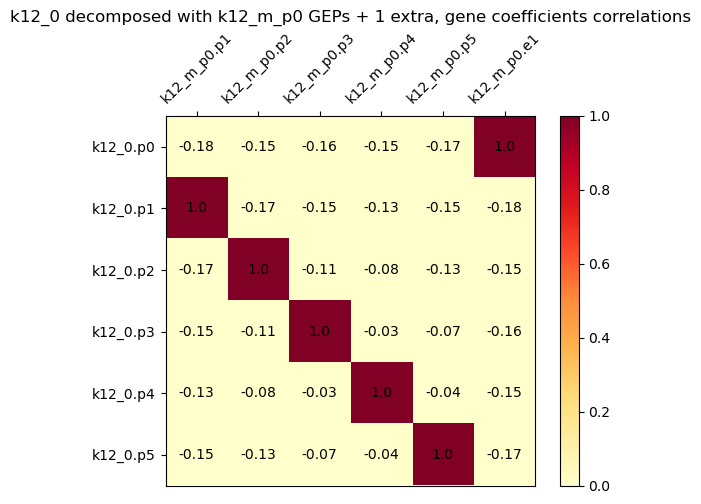

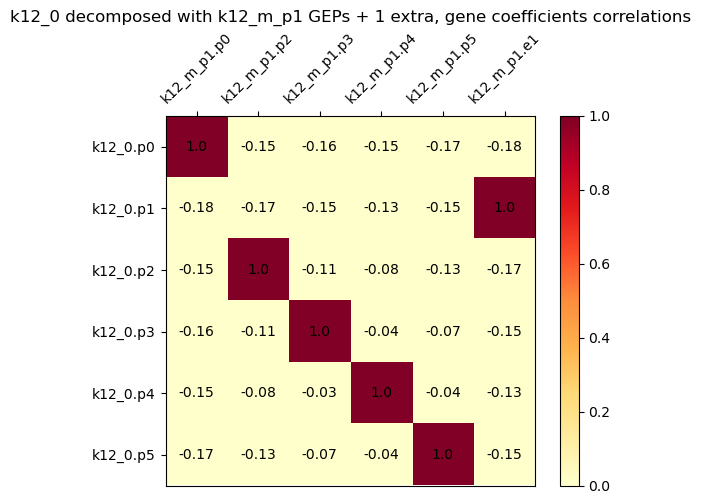

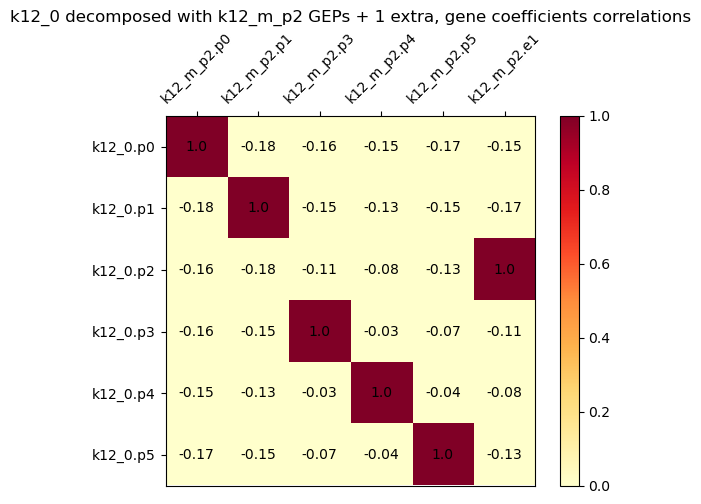

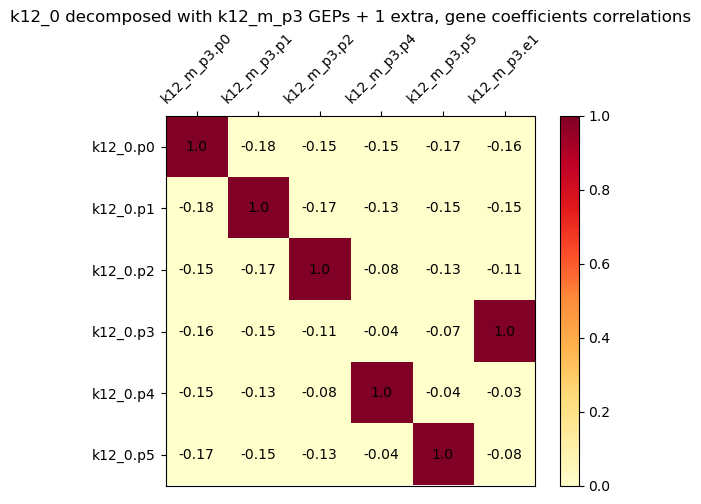

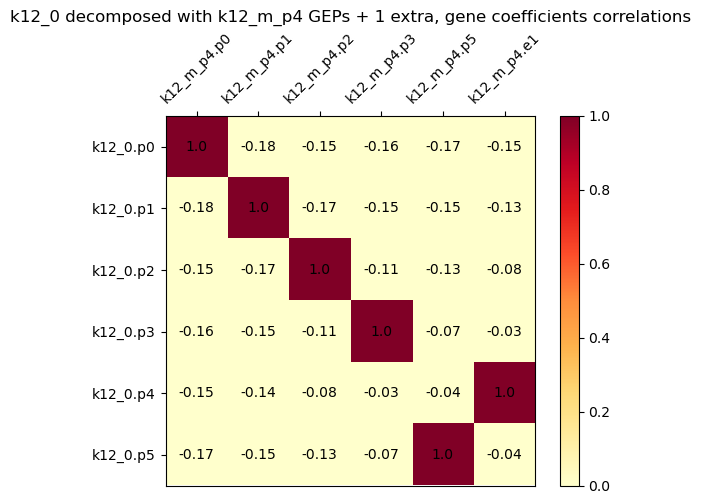

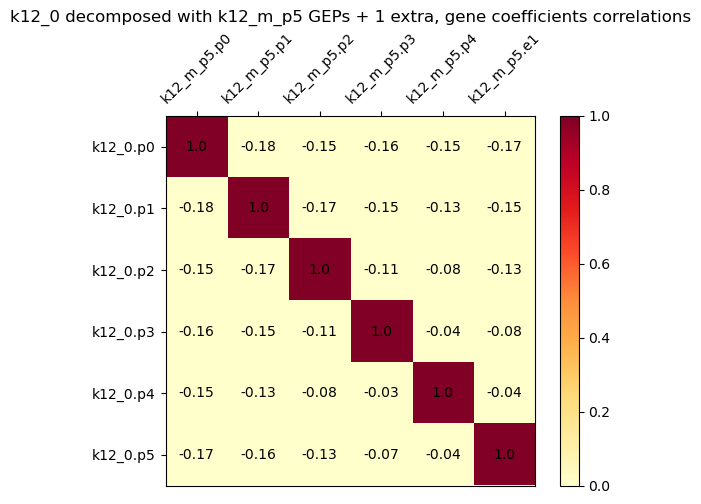

In [68]:
n_coefs = 400

for name, ns in recompositions.items():
    
    concatenated_spectras = pd.concat([orig_ns.gene_coefs__pfnmf[0],
                                       ns.gene_coefs__pfnmf[1]], axis=1)

    n_genes, n_programs = concatenated_spectras.shape

    ranked_coefs = n_genes - rankdata(concatenated_spectras, axis=0)
    
    ranked_coefs[ranked_coefs > n_coefs] = n_coefs
    
    spearman_corr = np.corrcoef(ranked_coefs, rowvar=False)
    
    ax = _utils.heatmap_with_numbers(
        spearman_corr[:orig_ns.rank, orig_ns.rank:],
        title=f'k12_0 decomposed with {name} GEPs + 1 extra, gene coefficients correlations', param_dict={'vmin': 0, 'vmax': 1})

    ax.set_xticks(ticks=ax.get_xticks(), labels=ns.gene_coefs__pfnmf[1].columns)
    ax.set_yticks(ticks=ax.get_yticks(), labels=orig_ns.nmf_prog_names)
    ax.tick_params(axis='x', labelrotation = 45)

    plt.show()
    plt.close()